Pour ce projet, nous avons suivi le sch√©ma pr√©sent√© dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

Avant de lancer ce NB, je lance le terminal Anaconda et je copie colle : 
mlflow server --host 127.0.0.1 --port 8080 

Ca lance MLFlow

# 1 - Pr√©sentation du projet
-----------------
Je suis Data Scientist au sein d'une soci√©t√© financi√®re, nomm√©e "Pr√™t √† d√©penser", qui propose des cr√©dits √† la consommation pour des personnes ayant peu ou pas du tout d'historique de pr√™t. L‚Äôentreprise souhaite mettre en ≈ìuvre un outil de ‚Äúscoring cr√©dit‚Äù pour calculer la probabilit√© qu‚Äôun client rembourse son cr√©dit, puis classifie la demande en cr√©dit accord√© ou refus√©. Elle souhaite donc d√©velopper un algorithme de classification en s‚Äôappuyant sur des sources de donn√©es vari√©es (donn√©es comportementales, donn√©es provenant d'autres institutions financi√®res, etc.).

# 2 - Les donn√©es
-----------------
Il existe 7 sources de donn√©es diff√©rentes :


* **application_train/application_test**: qui contiennent des informations sur chaque demande de pr√™t. Chaque pr√™t a sa propre ligne et est identifi√© par la caract√©ristique `SK_ID_CURR`. Les donn√©es du train sont accompagn√©es de la  `TARGET` qui indique 0 : le pr√™t a √©t√© rembours√© ou 1 : le pr√™t n'a pas √©t√© rembours√©. 
* **bureau**: les donn√©es concernant les cr√©dits ant√©rieurs du client aupr√®s d'autres institutions financi√®res. Chaque cr√©dit ant√©rieur a sa propre ligne dans le bureau, mais un pr√™t dans les donn√©es de la demande peut avoir plusieurs cr√©dits ant√©rieurs.
* **bureau_balance**: donn√©es mensuelles sur les cr√©dits ant√©rieurs dans le bureau. Chaque ligne correspond √† un mois d'un cr√©dit ant√©rieur, et un seul cr√©dit ant√©rieur peut avoir plusieurs lignes, une pour chaque mois de la dur√©e du cr√©dit. 
* **previous_application**: les demandes de cr√©dit ant√©rieures aupr√®s de Home Credit. Chaque pr√™t en cours dans les donn√©es de la demande peut avoir plusieurs pr√™ts ant√©rieurs. Chaque demande ant√©rieure a une ligne et est identifi√©e par la caract√©ristique `SK_ID_PREV`. 
* **POS_CASH_BALANCE**: des donn√©es mensuelles sur les pr√™ts au point de vente ou au comptant que les clients ont contract√©s aupr√®s de Home Credit. Chaque ligne correspond √† un mois d'un pr√™t au point de vente ou d'un pr√™t au comptant ant√©rieur, et un seul pr√™t ant√©rieur peut avoir plusieurs lignes.
* **credit_card_balance**: des donn√©es mensuelles sur les cartes de cr√©dit que les clients ont eues pr√©c√©demment avec Home Credit. Chaque ligne correspond √† un mois de solde de carte de cr√©dit, et une seule carte de cr√©dit peut avoir plusieurs lignes.
* **installments_payment** l'historique des paiements pour les pr√™ts pr√©c√©dents chez Home Credit. Il y a une ligne pour chaque paiement effectu√© et une ligne pour chaque paiement manqu√©. 



Voir sch√©ma tables pour assemblage : "C:\Users\belou\Projet 7\input\sch√©ma_tables.png"  
Voir dico variables : "C:\Users\belou\Projet 7\input\dico_variables.xlsx"

# 3 - Exploration des datasets Train et Test
--------------

Dans ce NB, nous nous en tiendrons √† utiliser uniquement les donn√©es de l'application_train et de l'application_test. Cela nous permettra d'√©tablir une base de r√©f√©rence que nous pourrons ensuite am√©liorer. 

## 3.1 - Imports

In [1]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from lightgbm import early_stopping

from mlflow.models import infer_signature

import shap
# Memory management
import gc 

## 3.2 - D√©couverte des donn√©es 

In [2]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

Le train comporte 307511 observations (chacune √©tant un pr√™t distinct) et 122 variables, y compris la target

In [3]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

Le test comporte bcp moins d'observations (48744) et ne comporte pas de  TARGET. 

In [9]:
app_train['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [10]:
app_test['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

## 3.3 - Exploratory Data Analysis

### 3.3.1 -  Distribution de la target

In [4]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [5]:
app_train['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

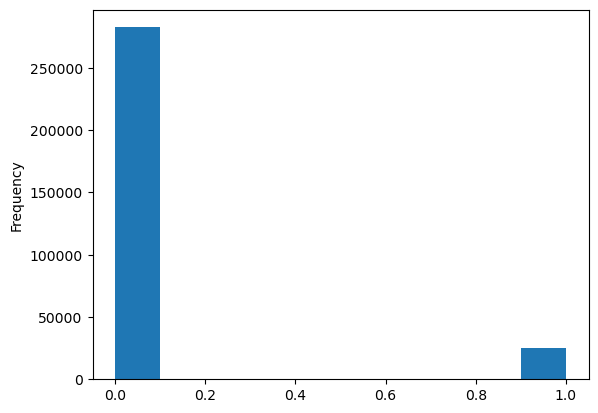

In [6]:
app_train['TARGET'].plot.hist();

Ces informations montrent qu'il s'agit d'un probl√®me de classe d√©s√©quilibr√©e :  il y a beaucoup plus de pr√™ts rembours√©s √† temps que de pr√™ts non rembours√©s. 

### 3.3.2 - Valeurs manquantes

In [10]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [11]:
# Statistiques des valeurs manquantes de l'app_train
missing_values = missing_values_table(app_train)
missing_values.head(20)


Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

In [13]:
missing_values.tail(20)

Missing Values  % of Total Values
TOTALAREA_MODE                      148431               48.3
EMERGENCYSTATE_MODE                 145755               47.4
OCCUPATION_TYPE                      96391               31.3
EXT_SOURCE_3                         60965               19.8
AMT_REQ_CREDIT_BUREAU_WEEK           41519               13.5
AMT_REQ_CREDIT_BUREAU_DAY            41519               13.5
AMT_REQ_CREDIT_BUREAU_MON            41519               13.5
AMT_REQ_CREDIT_BUREAU_QRT            41519               13.5
AMT_REQ_CREDIT_BUREAU_HOUR           41519               13.5
AMT_REQ_CREDIT_BUREAU_YEAR           41519               13.5
NAME_TYPE_SUITE                       1292                0.4
DEF_30_CNT_SOCIAL_CIRCLE              1021                0.3
OBS_60_CNT_SOCIAL_CIRCLE              1021                0.3
DEF_60_CNT_SOCIAL_CIRCLE              1021                0.3
OBS_30_CNT_SOCIAL_CIRCLE              1021                0.3
EXT_SOURCE_2                           660                0.2
AMT_GOODS_PRICE                        278                0.1
AMT_ANNUITY                             12                0.0
CNT_FAM_MEMBERS                          2                0.0
DAYS_LAST_PHONE_CHANGE                   1                0.0

Lorsqu'il s'agira de construire nos mod√®les d'apprentissage automatique, nous devrons imputer ces valeurs manquantes. Dans un travail ult√©rieur, nous utiliserons des mod√®les tels que XGBoost ou LightGBM qui peuvent traiter les valeurs manquantes sans n√©cessiter d'imputation.
Une autre option consisterait √† supprimer les colonnes pr√©sentant un pourcentage √©lev√© de valeurs manquantes, bien qu'il soit impossible de savoir √† l'avance si ces colonnes seront utiles √† notre mod√®le. 
Par cons√©quent, nous conserverons toutes les colonnes pour l'instant.

### 3.3.3 - Type des colonnes

In [9]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [10]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables cat√©gorielles ont un nombre relativement faible d'entr√©es uniques.

### 3.3.4 - Anomalies

Les anomalies dans les donn√©es sont un probl√®me que nous devons toujours surveiller lorsque nous faisons de l'AED. Celles-ci peuvent √™tre dues √† des chiffres mal saisis, √† des erreurs dans les mesures ou √† des mesures valables mais extr√™mes. L'une des fa√ßons de d√©tecter les anomalies de mani√®re quantitative est d'examiner les statistiques d'une colonne √† l'aide de la m√©thode `describe`. 

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
app_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

Les chiffres de la colonne `DAYS_BIRTH` sont n√©gatifs car ils sont enregistr√©s par rapport √† la demande de pr√™t en cours. Pour voir ces statistiques en ann√©es, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une ann√©e :

In [13]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces √¢ges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'√¢ge, que ce soit √† l'extr√©mit√© sup√©rieure ou inf√©rieure. Qu'en est-il des jours d'emploi ? 

In [14]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela ne semble pas correct ! La valeur maximale (en plus d'√™tre positive) est d'environ 1000 ans !

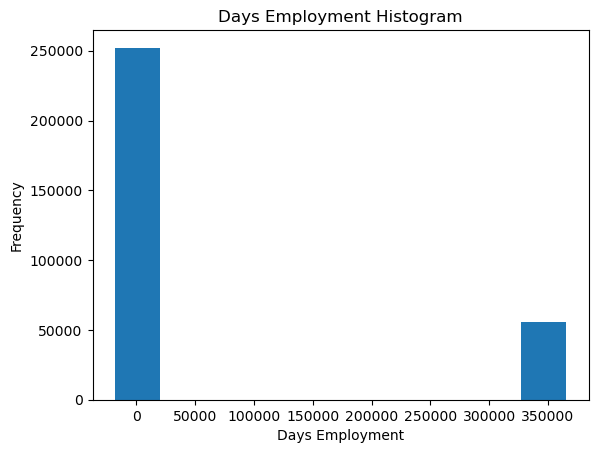

In [15]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Par simple curiosit√©, nous allons regrouper les clients pr√©sentant des anomalies et voir s'ils ont tendance √† avoir des taux de d√©faillance plus √©lev√©s ou plus faibles que le reste des clients.

In [16]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Il s'av√®re que les anomalies ont un taux de d√©faillance plus faible. 

Le traitement des anomalies d√©pend de la situation exacte et il n'existe pas de r√®gles fixes. L'une des approches les plus s√ªres consiste √† d√©finir les anomalies comme des valeurs manquantes et √† les compl√©ter (√† l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, comme toutes les anomalies ont exactement la m√™me valeur, nous voulons les compl√©ter avec la m√™me valeur au cas o√π tous ces pr√™ts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au mod√®le d'apprentissage automatique si nous avons effectivement renseign√© ces valeurs. Comme solution, nous allons remplir les valeurs anormales avec un nombre (`np.nan`) et ensuite cr√©er une nouvelle colonne bool√©enne indiquant si la valeur √©tait anormale ou non.



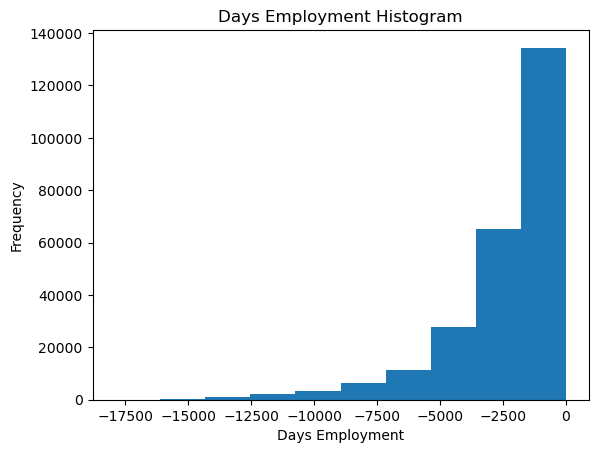

In [17]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Tout ce que nous faisons sur les donn√©es d'entra√Ænement, nous devons √©galement le faire sur les donn√©es de test. Veillons √† cr√©er la nouvelle colonne et √† remplir la colonne existante avec np.nan dans les donn√©es de test.

In [18]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


La distribution semble beaucoup plus conforme √† ce que nous attendons, et nous avons √©galement cr√©√© une nouvelle colonne pour indiquer au mod√®le que ces valeurs √©taient √† l'origine anormales (parce que nous devrons remplir les nans avec une valeur, probablement la m√©diane de la colonne). Les autres colonnes avec `DAYS` dans le cadre de donn√©es semblent √™tre √† peu pr√®s ce que nous attendons, sans valeurs aberrantes √©videntes. 

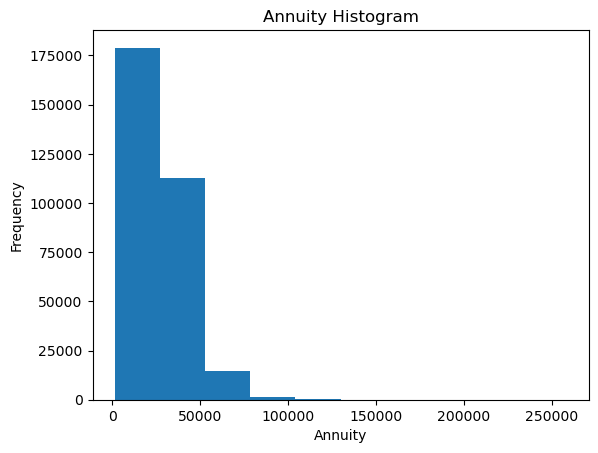

In [19]:
app_train['AMT_ANNUITY'].plot.hist(title = 'Annuity Histogram');
plt.xlabel('Annuity');

### 3.3.5 - Correlations

Une fa√ßon d'essayer de comprendre les donn√©es est de rechercher des corr√©lations entre les variables et la cible. Nous pouvons calculer le coefficient de corr√©lation de Pearson entre chaque variable et la cible √† l'aide de la m√©thode .corr dataframe.

Le coefficient de corr√©lation n'est pas la meilleure m√©thode pour repr√©senter la ¬´ pertinence ¬ª d'une caract√©ristique, mais il nous donne une id√©e des relations possibles entre les donn√©es. Voici quelques interpr√©tations g√©n√©rales de la valeur absolue du coefficient de corr√©lation :

* .00-.19 ‚Äúvery weak‚Äù
*  .20-.39 ‚Äúweak‚Äù
*  .40-.59 ‚Äúmoderate‚Äù
*  .60-.79 ‚Äústrong‚Äù
* .80-1.0 ‚Äúvery strong‚Äù


In [20]:
numeric_columns=app_train.select_dtypes(include=np.number).columns.tolist()
numeric_columns

# Matrice de corr√©lation
correlations = app_train[numeric_columns].corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227


La corr√©lation `DAYS_BIRTH` est la plus positive. En regardant la documentation, `DAYS_BIRTH` est l'√¢ge en jours du client au moment du pr√™t en jours n√©gatifs. La corr√©lation est positive, mais la valeur de cette caract√©ristique est en fait n√©gative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son pr√™t (c'est-√†-dire la cible == 0). C'est un peu d√©routant, nous prendrons donc la valeur absolue de la caract√©ristique et la corr√©lation sera n√©gative.

#### 3.3.5.1 - Effet de l'√¢ge sur le remboursement

In [21]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Plus le client est √¢g√©, plus il existe une relation lin√©aire n√©gative avec la cible, ce qui signifie que plus les clients sont √¢g√©s, plus ils ont tendance √† rembourser leurs pr√™ts √† temps. 

Commen√ßons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'√¢ge. L'axe des x sera exprim√© en ann√©es pour rendre le graphique un peu plus compr√©hensible.

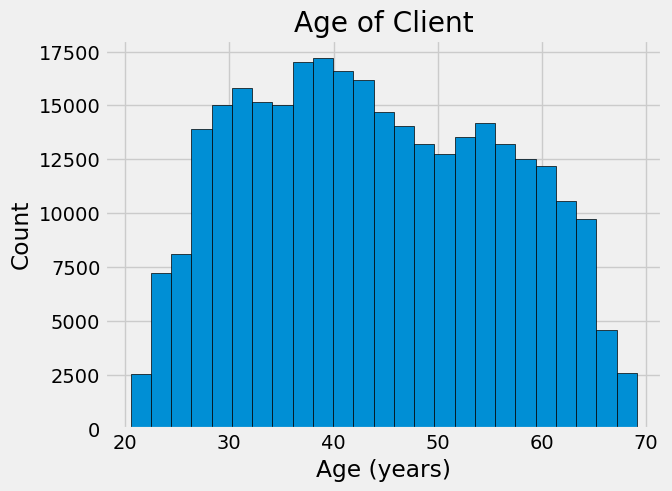

In [22]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'√¢ge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les √¢ges sont raisonnables.
Pour visualiser l'effet de l'√¢ge sur la cible, nous ferons ensuite un graphique d'estimation de la densit√© du noyau (KDE) color√© par la valeur de la cible. Un graphique d'estimation de la densit√© du noyau montre la distribution d'une seule variable et peut √™tre consid√©r√© comme un histogramme liss√© (il est cr√©√© en calculant un noyau, g√©n√©ralement une gaussienne, √† chaque point de donn√©es, puis en faisant la moyenne de tous les noyaux individuels pour d√©velopper une seule courbe lisse). Nous utiliserons le `kdeplot` de seaborn pour ce graphique.

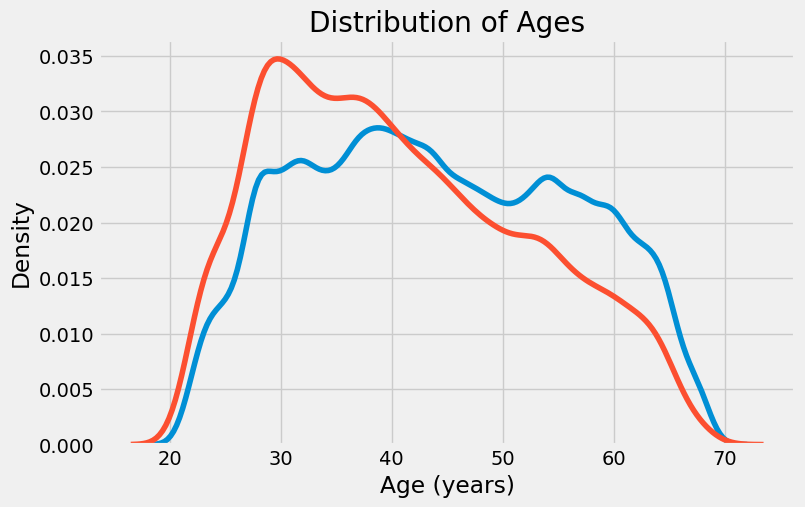

In [23]:
plt.figure(figsize = (8, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe de la Target == 1 penche vers l'extr√©mit√© la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corr√©lation significative (coefficient de corr√©lation de -0,07), cette variable sera probablement utile dans un mod√®le d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des pr√™ts par tranche d'√¢ge. 

Pour cr√©er ce graphique, nous commen√ßons par ¬´ d√©couper ¬ª la cat√©gorie d'√¢ge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de pr√™ts non rembours√©s dans chaque cat√©gorie d'√¢ge.

In [24]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [25]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

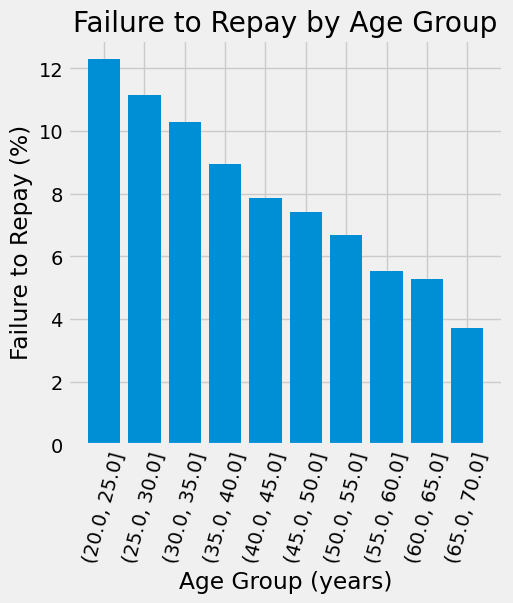

In [26]:
plt.figure(figsize = (5, 5))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le pr√™t ! Le taux de non-remboursement est sup√©rieur √† 10 % pour les trois groupes d'√¢ge les plus jeunes et inf√©rieur √† 5 % pour le groupe le plus √¢g√©.

Il s'agit d'une information qui pourrait √™tre directement utilis√©e par la banque : √©tant donn√© que les jeunes clients sont moins susceptibles de rembourser le pr√™t, il conviendrait peut-√™tre de leur fournir davantage de conseils ou d'astuces en mati√®re de planification financi√®re. Cela ne signifie pas que la banque doive discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de pr√©caution pour les aider √† rembourser √† temps.

#### 3.3.5.2 - Sources Ext√©rieures

Les 3 variables ayant les corr√©lations n√©gatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`.
Selon la documentation, ces caract√©ristiques repr√©sentent un ¬´ score normalis√© de la source de donn√©es externe ¬ª. Il est difficile de comprendre ce que cela signifie exactement, mais il pourrait s'agir d'une sorte d'√©valuation de cr√©dit cumulative r√©alis√©e √† partir de nombreuses sources de donn√©es. 

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corr√©lations des caract√©ristiques `EXT_SOURCE` avec la cible et entre elles.

In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

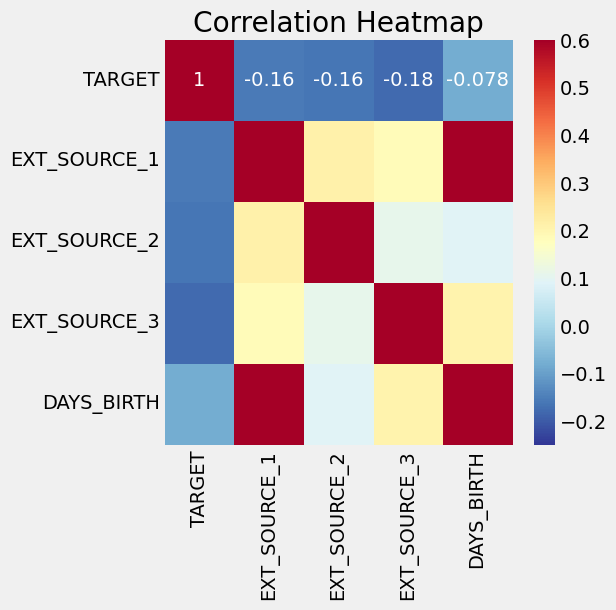

In [28]:
plt.figure(figsize = (5, 5))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caract√©ristiques EXT_SOURCE ont des corr√©lations n√©gatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le pr√™t. Nous pouvons √©galement constater que DAYS_BIRTH est positivement corr√©l√© avec EXT_SOURCE_1, ce qui indique que l'√¢ge du client est peut-√™tre l'un des facteurs de ce score.

Nous pouvons ensuite examiner la distribution de chacune de ces caract√©ristiques en fonction de la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

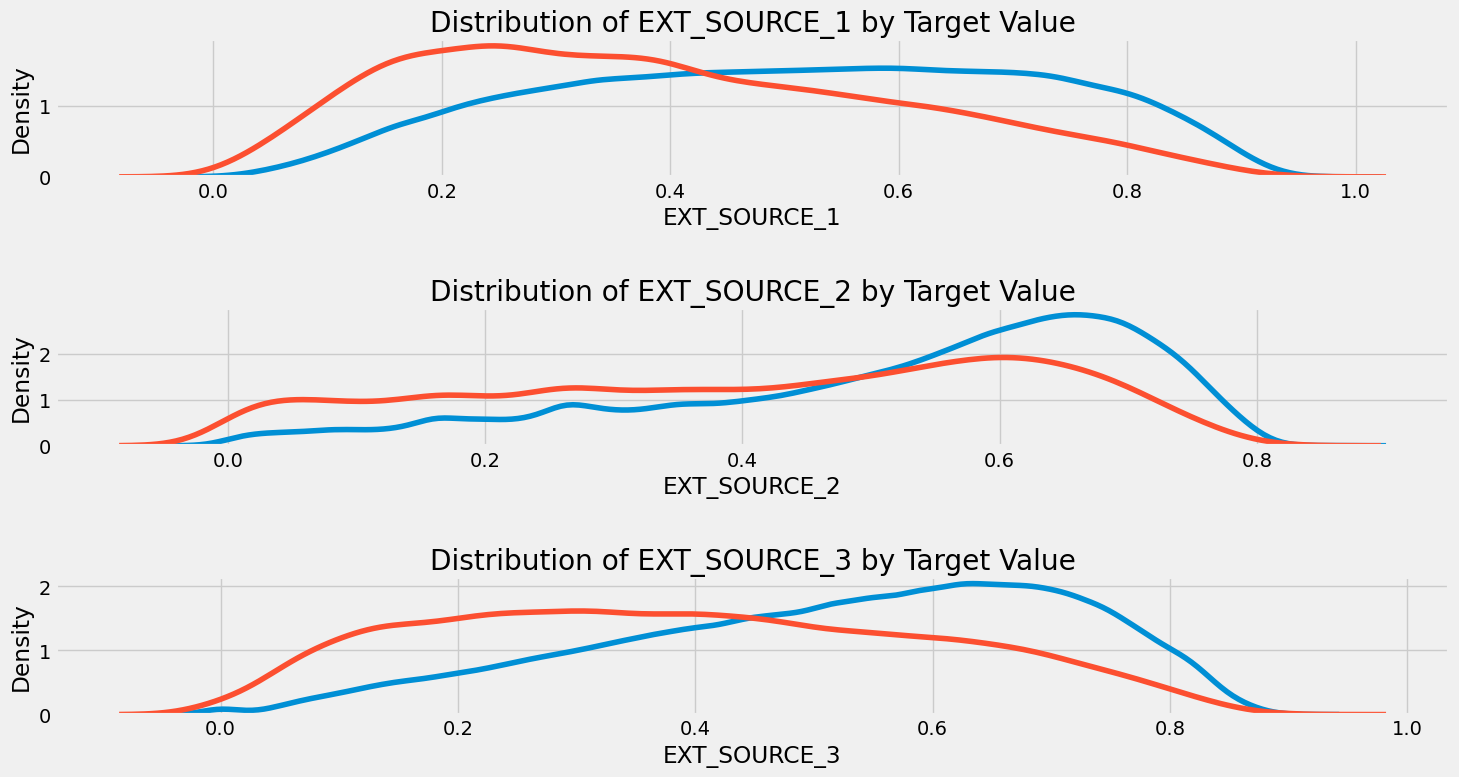

In [29]:
plt.figure(figsize = (15, 8))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` affiche la plus grande diff√©rence entre les valeurs de la cible. Nous pouvons clairement voir que cette caract√©ristique a une certaine relation avec la probabilit√© qu'un demandeur rembourse un pr√™t. La relation n'est pas tr√®s forte (en fait, elles sont toutes consid√©r√©es comme tr√®s faibles, mais ces variables seront toujours utiles pour un mod√®le d'apprentissage automatique permettant de pr√©dire si un demandeur remboursera ou non un pr√™t dans les d√©lais.

In [30]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

In [31]:
app_train_domain.to_csv('app_train_domain.csv', index=False)
app_test_domain.to_csv('app_test_domain.csv', index=False)


# 4 - Mod√©lisation

In [32]:
# d√©marrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

### 4.1 - Split train en train/test

Je garde une copie du df intact avec les id clients et la target

In [33]:
app_train_origin=app_train_domain.copy()

In [34]:
ID = app_train_domain['SK_ID_CURR'] 
X = app_train_domain.drop(['SK_ID_CURR','TARGET'], axis=1)  
y = app_train_domain['TARGET']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 4.2 - Encoding Variables cat√©gorielles

Un mod√®le d'apprentissage automatique ne peut pas traiter les variables cat√©gorielles (√† l'exception de certains mod√®les tels que LightGBM : http://lightgbm.readthedocs.io/en/latest/Features.html). 

Nous devons donc trouver un moyen d'encoder (repr√©senter) ces variables sous forme de nombres avant de les transmettre au mod√®le. Il y a deux fa√ßons principales d'effectuer ce processus :
- Label encoding: attribue un nombre entier √† chaque cat√©gorie unique d'une variable cat√©gorielle.
- One-hot encoding: cr√©√© une nouvelle colonne pour chaque cat√©gorie unique dans une variable cat√©gorielle. Chaque observation re√ßoit un 1 dans la colonne de la cat√©gorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

Le probl√®me du Label encoding est qu'il donne aux cat√©gories un ordre arbitraire. La valeur attribu√©e √† chacune des cat√©gories est al√©atoire et ne refl√®te aucun aspect inh√©rent √† la cat√©gorie. Dans l'exemple ci-dessus, le programmeur re√ßoit un 4 et le scientifique des donn√©es un 1, mais si nous refaisions le m√™me processus, les √©tiquettes pourraient √™tre invers√©es ou compl√®tement diff√©rentes. L'affectation r√©elle des nombres entiers est arbitraire. Par cons√©quent, lorsque nous proc√©dons √† l'encodage des √©tiquettes, le mod√®le peut utiliser la valeur relative de la caract√©ristique (par exemple, programmeur = 4 et scientifique = 1) pour attribuer des poids, ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable cat√©gorielle (telle que Homme/Femme), le Label Encoding convient, mais pour plus de deux cat√©gories uniques, le One Hot Encoding est l'option la plus s√ªre.

Le seul inconv√©nient du One Hot Encoding est que le nombre de caract√©ristiques (dimensions des donn√©es) peut exploser avec des variables cat√©gorielles comportant de nombreuses cat√©gories. Pour y rem√©dier, nous pouvons effectuer un OHE suivi d'une ACP ou d'autres m√©thodes de r√©duction de la dimensionnalit√© afin de r√©duire le nombre de dimensions tout en essayant de pr√©server l'information. 

Dans ce NB, nous utiliserons le Label Encoding pour toutes les variables cat√©gorielles comportant seulement deux cat√©gories et le OHE pour toutes les variables cat√©gorielles comportant plus de deux cat√©gories. Il se peut que ce processus doive √™tre modifi√© au fur et √† mesure que nous avan√ßons dans le projet, mais pour l'instant, nous allons voir o√π cela nous m√®ne. 

In [35]:
# Create a label encoder object
le = LabelEncoder()

# Iterate through the columns
le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
        # Apply the label encoder to both training and test sets
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


In [36]:
print('Training Features shape: ', X_train.shape)
print('Test Features shape: ', X_test.shape)

Training Features shape:  (246008, 121)
Test Features shape:  (61503, 121)


In [37]:
# Pr√©traitement : One-Hot Encoding pour les variables cat√©gorielles
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

print('Training Features shape: ', X_train_ohe.shape)
print('Test Features shape: ', X_test_ohe.shape)


Training Features shape:  (246008, 242)
Test Features shape:  (61503, 242)


Il doit y avoir les m√™mes colonnes dans le train et dans le test. Si le OHE a cr√©√© plus de colonnes dans le train que dans le test (parce qu'il y avait des variables cat√©gorielles dont les cat√©gories n'√©taient pas repr√©sent√©es dans les donn√©es de test), alors il faut supprimer les colonnes des donn√©es d'apprentissage qui ne se trouvent pas dans les donn√©es de test. Pour √ßa, nous devons ¬´ aligner ¬ª les cadres de donn√©es. 

In [38]:
# Assurons-nous que X_train et X_test ont les m√™mes colonnes
X_train_ohe, X_test_ohe = X_train_ohe.align(X_test_ohe, join='inner', axis=1)

print('Training Features shape: ', X_train_ohe.shape)
print('Val Features shape: ', X_test_ohe.shape)


Training Features shape:  (246008, 242)
Val Features shape:  (61503, 242)


Rmq : Lorsqu'on utilise la m√©thode align() avec l'option join='inner' pour aligner deux DataFrames pandas sur l'axe des colonnes, toutes les colonnes qui ne sont pas communes aux deux DataFrames sont supprim√©es du r√©sultat final. Cela signifie que toute information contenue dans ces colonnes supprim√©es est perdue dans les DataFrames retourn√©s par la m√©thode.

## 4.3 - Imputation MV et normalisation avec un min max scaler

In [39]:
from sklearn.preprocessing import MinMaxScaler

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))


X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_ohe), columns=X_train_ohe.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_ohe), columns=X_test_ohe.columns)
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_imp.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_imp.columns)



print('Training data shape: ', X_train_sc.shape)
print('Testing data shape: ', X_test_sc.shape)


Training data shape:  (246008, 242)
Testing data shape:  (61503, 242)


In [40]:
X_train_sc.head()

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                 0.0           1.0              0.0      0.000000   
1                 0.0           0.0              1.0      0.052632   
2                 0.0           1.0              1.0      0.000000   
3                 0.0           1.0              1.0      0.052632   
4                 0.0           0.0              1.0      0.000000   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.010787    0.127409     0.057529         0.105499   
1          0.009785    0.038224     0.085890         0.032548   
2          0.008115    0.182598     0.091874         0.151515   
3          0.010278    0.213483     0.137171         0.214366   
4          0.014795    0.122015     0.076746         0.108866   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.491595    0.894025       0.908106           0.846472   
1                    0.134897    0.193461       0.993468           0.817176   
2                    0.491595    0.886359       0.879578           0.757431   
3                    0.421848    0.181172       0.858754           0.888196   
4                    0.344429    0.468377       0.803484           0.658097   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.387523     0.340659         1.0             0.0              0.0   
1         0.527720     0.098901         1.0             1.0              1.0   
2         0.304016     0.087912         1.0             1.0              0.0   
3         0.617757     0.164835         1.0             1.0              1.0   
4         0.305127     0.098901         1.0             1.0              0.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0               1.0         0.0         0.0         0.000000   
1               1.0         1.0         0.0         0.105263   
2               1.0         0.0         0.0         0.052632   
3               1.0         1.0         0.0         0.105263   
4               1.0         0.0         0.0         0.052632   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                   0.5                          0.5                 0.391304   
1                   0.5                          0.5                 0.304348   
2                   0.5                          0.5                 0.565217   
3                   0.5                          0.5                 0.434783   
4                   0.5                          0.5                 0.521739   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                     0.0                      0.0      0.544382   
1                     0.0                      0.0      0.245832   
2                     0.0                      0.0      0.524898   
3                     1.0                      1.0      0.292484   
4                     0.0                      0.0      0.827744   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.419378      0.629055          0.0876            0.0763   
1      0.573456      0.664367          0.0784            0.0633   
2      0.752520      0.788042        

## 4.4 - Baseline = Dummy Classifier

Pour obtenir une baseline :
- nous utiliserons toutes les caract√©ristiques apr√®s avoir encod√© les variables cat√©gorielles.
- Nous allons pr√©traiter les donn√©es en remplissant les valeurs manquantes (imputation)
- et normaliser les caract√©ristiques.


### 4.4.1 - Entrainement et pr√©dictions

Pour avoir une r√©f√©rence et, comme le jeu de donn√©es est d√©s√©quilibr√©, on va tester un mod√®le na√Øf avec la strat√©gie 'stratified', qui va g√©n√©rer des pr√©dictions en respectant la distribution des classes de l'ensemble d'entrainement

In [41]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Entra√Ænement du Dummy Classifier
start_time=time.time()

dummy_clf.fit(X_train_sc, y_train)

end_time = time.time()
training_execution_time = round(end_time - start_time, 2)
print(f"Le temps d'entrainement est de {training_execution_time} secondes.")

Le temps d'entrainement est de 0.01 secondes.


Maintenant que le mod√®le a √©t√© entra√Æn√©, nous pouvons l'utiliser pour faire des pr√©dictions. Nous voulons pr√©dire les probabilit√©s de ne pas rembourser un pr√™t, nous utilisons donc la m√©thode `predict.proba` du mod√®le. Celle-ci renvoie un tableau m x 2 o√π m est le nombre d'observations. La premi√®re colonne est la probabilit√© que la cible soit 0 et la deuxi√®me colonne est la probabilit√© que la cible soit 1 (donc pour une seule ligne, la somme des deux colonnes doit √™tre √©gale √† 1). Nous voulons conna√Ætre la probabilit√© que le pr√™t ne soit pas rembours√©, nous s√©lectionnerons donc la deuxi√®me colonne.

Le code suivant effectue les pr√©dictions et s√©lectionne la colonne correcte.

In [42]:
# Pr√©dictions 
start_time=time.time()

y_pred_dummy_train = dummy_clf.predict(X_train_sc)
dummy_pred_train = dummy_clf.predict_proba(X_train_sc)[:, 1]

end_time = time.time()
predicting_execution_time = round(end_time - start_time, 2)
print(f"Le temps de pr√©diction sur le train est de {predicting_execution_time} secondes.")

y_pred_dummy_test = dummy_clf.predict(X_test_sc)
dummy_pred_test = dummy_clf.predict_proba(X_test_sc)[:, 1]


Le temps de pr√©diction sur le train est de 0.02 secondes.


### 4.4.2 - Evaluation

#### 4.4.2.1 - Confusion matrix et Classification Reports

In [43]:
pd.crosstab(y_test, y_pred_dummy_test, rownames=['Classes r√©elles'], colnames=['Classes pr√©dites'])

Classes pr√©dites      0     1
Classes r√©elles              
0                 52008  4546
1                  4576   373

In [44]:
print(classification_report(y_test, y_pred_dummy_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



Ce mod√®le na√Øf, bien qu'ayant une tr√®s bonne accuracy globale (85%), se r√©v√®le √™tre tr√®s peu performant sur la classe minoritaire (1) avec un f1 score de 0.08. Regardons dans le d√©tail :

**- Pr√©cision de 0.08 sur la classe 1** :  ratio du nombre de vrais positifs (TP) sur le total des pr√©dictions positives (TP + FP) pour cette classe. Une pr√©cision de 0.08 signifie que parmi toutes les instances que le mod√®le a pr√©dites comme appartenant √† la classe 1, seulement 8% √©taient r√©ellement de la classe 1. En d'autres termes, **92% des pr√©dictions positives pour la classe 1 √©taient des faux positifs (FP)**.  

**- Rappel (Recall) de 0.08 sur la classe 1** : ratio du nombre de vrais positifs (TP) sur le total des instances r√©elles de la classe 1 (TP + FN). Un rappel de 0.08 signifie que le mod√®le n'a identifi√© correctement que 8% des instances r√©elles de la classe 1. En d'autres termes, **92% des instances r√©elles de la classe 1 ont √©t√© class√©es √† tort comme appartenant √† la classe 0 (FN).**



#### 4.4.2.2 - AUC du train et du test

La courbe ROC est un graphe qui trace le taux de vrais positifs (True Positive Rate, ou TPR) contre le taux de faux positifs (False Positive Rate, ou FPR) √† diff√©rents seuils de d√©cision. L'AUC est l'aire sous la courbe ROC. Elle mesure la capacit√© du mod√®le √† distinguer entre les classes positives et n√©gatives. Une AUC de 0.5 signifie que le mod√®le a une performance √©quivalente √† une pr√©diction al√©atoire. Une AUC de 1.0 signifie que le mod√®le est parfait pour distinguer entre les classes positives et n√©gatives. Contrairement √† des m√©triques comme la pr√©cision ou le rappel, qui d√©pendent d'un seuil de d√©cision sp√©cifique, l'AUC √©value la performance du mod√®le sur tous les seuils possibles. Cela en fait une mesure plus robuste et globale de la performance du mod√®le.

In [45]:
# Calculer l'AUC sur le train
auc_train = round(roc_auc_score(y_train, dummy_pred_train),2)
print("Train AUC:", auc_train)

Train AUC: 0.5


In [46]:
# Calculer l'AUC sur le test
auc_test = round(roc_auc_score(y_test, dummy_pred_test),2)
print("Test AUC:", auc_test)

Test AUC: 0.5


Ce mod√®le na√Øf a une performance √©quivalente √† une pr√©diction al√©atoire. Il va nous servir de base de travail.

Avant de le comparer √† d'autres mod√®les plus performants, nous allons √©laborer le score m√©tier tenant compte du d√©s√©quilibre entre les bons et moins bons clients

### 4.4.3 - Elaboration du score m√©tier

#### 4.4.3.1 - D√©finition de la matrice de co√ªts

Le d√©s√©quilibre entre le nombre de bons et de moins bons clients doit √™tre pris en compte pour √©laborer un mod√®le pertinent. Nous allons attribuer un co√ªt m√©tier 10 fois plus √©lev√© pour un faux n√©gatif (FN - mauvais client pr√©dit bon client : donc cr√©dit accord√© et perte en capital) que pour un faux positif (FP - bon client pr√©dit mauvais : donc refus cr√©dit et manque √† gagner en marge)

- Faux N√©gatif (FN) : un mauvais client est pr√©dit comme bon. Fixons ce co√ªt √† 10.
- Faux Positif (FP) : un bon client est pr√©dit comme mauvais. Fixons ce co√ªt √† 1.

#### 4.4.3.2 - Calcul du co√ªt total des erreurs

On construit une fonction qui va calculer, pour chaque seuil de probabilit√© p utilis√© pour classifier les observations en positives (clients d√©faillants) ou n√©gatives (bons clients), le co√ªt total des erreurs comme suit :
- on va calculer le nombre de FN et FP pour le seuil p
- on va calculer le co√ªt total : co√ªt total (p) = co√ªt FN x Nbre FN + Co√ªt FP x Nbre FP

In [47]:
def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    """
    Calcule le co√ªt personnalis√© pour un seuil donn√© dans une classification binaire en utilisant les co√ªts
    des faux n√©gatifs et des faux positifs.

    Param√®tres :
    -----------
    y_true : array-like
        Vecteur des √©tiquettes vraies (0 ou 1).
    
    probas : array-like
        Vecteur des probabilit√©s pr√©dites par le mod√®le pour la classe positive (1).
    
    threshold : float
        Seuil de probabilit√© utilis√© pour convertir les probabilit√©s en √©tiquettes binaires.
    
    cost_fn : float
        Co√ªt associ√© √† un faux n√©gatif (FN).
    
    cost_fp : float
        Co√ªt associ√© √† un faux positif (FP).

    Retourne :
    --------
    cost : float
        Le co√ªt total calcul√© en utilisant le nombre de faux n√©gatifs et faux positifs et leurs co√ªts respectifs.

    Description :
    ------------
    La fonction transforme les probabilit√©s pr√©dites en √©tiquettes binaires en utilisant un seuil donn√©. 
    Les probabilit√©s sup√©rieures ou √©gales au seuil sont marqu√©es comme positives (1), sinon comme n√©gatives (0).
    Elle calcule ensuite les valeurs de la matrice de confusion (TN, FP, FN, TP) et renvoie le co√ªt total bas√© sur
    les co√ªts fournis pour les faux n√©gatifs et les faux positifs.

    Exemple :
    --------
    >>> y_true = [0, 1, 0, 1, 1]
    >>> probas = [0.1, 0.4, 0.35, 0.8, 0.7]
    >>> threshold = 0.5
    >>> cost_fn = 10
    >>> cost_fp = 1
    >>> calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp)
    11
    """
    y_pred = (probas >= threshold).astype(int)  # transforme les probas en pr√©dictions binaires en utilisant un seuil.
                                                # Les probabilit√©s >= au seuil sont marqu√©es comme 1 (positives),
                                                # les autres comme 0 (n√©gatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  # .ravel() convertit la matrice 2x2 en un tableau √† une dimension [tn, fp, fn, tp]
                                                               # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp


#### 4.4.3.3 - Optimisation du seuil

Il va s'agir d'utiliser une m√©thode pour trouver le seuil p qui minimise le Cout total.  

In [48]:
thresholds = np.linspace(0, 1, 100) # g√©n√©re 100 valeurs de seuil uniform√©ment r√©parties entre 0 et 1

costs = [calculate_cost_threshold(y_test, dummy_pred_test, thr, cost_fn=10, cost_fp=1) for thr in thresholds]


In [49]:
# On cherche le seuil qui minimise le co√ªt
optimal_threshold = round(thresholds[np.argmin(costs)],2) # d√©termine le seuil optimal en trouvant l'indice du co√ªt minimal 
                                                        # dans la liste costs √† l'aide de np.argmin(), 
                                                        # puis en r√©cup√©rant la valeur correspondante dans thresholds. La valeur est arrondie √† 2 d√©cimales pour plus de lisibilit√©.
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.01


Ici, le seuil qui mnimise le co√ªt m√©tier est 0.01

### 4.4.4 - Analyse des r√©sultats du test au seuil optimal

Nous faisons ici une nouvelle matrice de confusion et de nouvelles mesures de performances pour ce seuil optimal 

#### 4.4.4.1 - Confusion matrix et Classification Reports au seuil optimal

In [50]:
y_pred_optimal = (dummy_pred_test >= optimal_threshold).astype(int)

Rmq : (dummy_pred_test >= optimal_threshold) effectue une comparaison √©l√©ment par √©l√©ment entre les probabilit√©s pr√©dites et le seuil optimal. Cela cr√©e un tableau de bool√©ens o√π chaque √©l√©ment est True si la probabilit√© pr√©dite est sup√©rieure ou √©gale au seuil optimal, sinon False.
.astype(int) est utilis√© pour convertir les valeurs bool√©ennes (True/False) en entiers (1/0). Ainsi, les valeurs sup√©rieures ou √©gales au seuil optimal seront converties en 1 et les autres en 0.
Le r√©sultat final, y_pred_optimal, est un tableau de pr√©dictions binaires o√π chaque √©l√©ment est 1 si la probabilit√© pr√©dite correspondante est sup√©rieure ou √©gale au seuil optimal, sinon 0.

In [51]:
pd.crosstab(y_test, y_pred_optimal, rownames=['Classes r√©elles'], colnames=['Classes pr√©dites'])

Classes pr√©dites      0     1
Classes r√©elles              
0                 52008  4546
1                  4576   373

In [52]:
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



#### 4.4.4.2 - R√©cup√©ration du recall et f1 score de la classe 1 + accuracy globale au seuil optimal

Pour enregistrer ces valeurs dans MLFlow

In [53]:
report = classification_report(y_test, y_pred_optimal, output_dict=True) # output_dict=True indique √† la fonction classification_report 
                                                    # de renvoyer le rapport sous forme de dictionnaire Python plut√¥t que sous forme de cha√Æne de caract√®res.

In [54]:
report

{'0': {'precision': 0.9191290824261276,
  'recall': 0.9196166495738586,
  'f1-score': 0.919372801357634,
  'support': 56554.0},
 '1': {'precision': 0.07582842041065257,
  'recall': 0.07536876136593251,
  'f1-score': 0.07559789217673288,
  'support': 4949.0},
 'accuracy': 0.8516820317708079,
 'macro avg': {'precision': 0.49747875141839004,
  'recall': 0.49749270546989555,
  'f1-score': 0.4974853467671834,
  'support': 61503.0},
 'weighted avg': {'precision': 0.851270685659879,
  'recall': 0.8516820317708079,
  'f1-score': 0.8514762430509452,
  'support': 61503.0}}

In [55]:
recall_1_test = round(report['1']['recall'],2)
print(f"Recall for class '1': {recall_1_test}")

Recall for class '1': 0.08


In [56]:
f1_score_1_test = round(report['1']['f1-score'],2)
print(f"F1 Score for class '1': {f1_score_1_test}")

F1 Score for class '1': 0.08


In [57]:
accuracy_test = round(accuracy_score(y_test, y_pred_optimal),2)
print("Accuracy du test:", accuracy_test)

Accuracy du test: 0.85


### 4.4.5 - Enregistrement du mod√®le dans MLFlow

In [58]:
# Utilisation d'un √©chantillon de 10 lignes comme exemple d'entr√©e
input_example = X_train_sc.sample(n=10, random_state=42)

In [59]:
# # Cr√©ation d'une nouvelle exp√©rience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai d√©clar√©s au dessus
#     # mlflow.log_params(params)

#     # Log la m√©trique de perte que j'ai d√©clar√©e au dessus
    
#     mlflow.log_metric("optimal_threshold", optimal_threshold)

#     mlflow.log_metric("recall_1_test", recall_1_test)
#     mlflow.log_metric("f1_score_1_test", f1_score_1_test)
#     mlflow.log_metric("accuracy du test", accuracy_test)
    
#     mlflow.log_metric("auc_train", auc_train)
#     mlflow.log_metric("auc_test", auc_test)
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", predicting_execution_time)

    
    

#     # D√©finir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Dummy model _ Methode Stratified ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, dummy_clf.predict(X_train_sc)) # infer_signature g√©n√®re automatiquement une "signature" 
#                                                               # qui d√©crit les entr√©es et les sorties du mod√®le. 
#                                                               # Cela inclut les types de donn√©es et les formats attendus par le mod√®le, 
#                                                               # facilitant ainsi l'int√©gration et la r√©utilisation du mod√®le 
#                                                               # dans diff√©rents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=dummy_clf, # le mod√®le
#         artifact_path="dummy_model", # le chemin o√π le mod√®le sera enregistr√©
#         signature=signature, # la signature du mod√®le
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le mod√®le
#         registered_model_name="scoring-credit-dummy", # nom sous lequel le mod√®le est enregistr√© dans le registre de mod√®les MLflow
#     )


Comparons maintenant notre mod√®le na√Øf √† une r√©gression logistique

## 4.5 - R√©gression logistique 

### 4.5.1 - Cr√©ation de fonctions de scoring

In [60]:
def custom_f1(y_true, y_pred_proba):
    """
    Calcule le meilleur F1 score pour un mod√®le de classification binaire en s√©lectionnant le seuil
    de probabilit√© qui minimise un co√ªt personnalis√© bas√© sur les faux n√©gatifs et les faux positifs.

    Param√®tres :
    -----------
    y_true : array-like
        Vecteur des √©tiquettes vraies (0 ou 1).

    y_pred_proba : array-like
        Vecteur des probabilit√©s pr√©dites par le mod√®le pour la classe positive (1).

    Retourne :
    --------
    best_f1 : float
        Le meilleur F1 score obtenu en utilisant le seuil optimal.

    Description :
    ------------
    La fonction parcourt une gamme de seuils de probabilit√© (de 0 √† 1) pour convertir les
    probabilit√©s pr√©dites en √©tiquettes binaires. Pour chaque seuil, elle calcule le F1 score et
    un co√ªt d√©fini comme suit :
        co√ªt = (nombre de faux n√©gatifs) * 10 + (nombre de faux positifs)
    Le meilleur F1 score est celui obtenu avec le seuil qui minimise ce co√ªt.

    Exemple :
    --------
    >>> y_true = [0, 1, 0, 1, 1]
    >>> y_pred_proba = [0.1, 0.4, 0.35, 0.8, 0.7]
    >>> custom_f1(y_true, y_pred_proba)
    0.6666666666666666
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les co√ªts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # S√©lectionner le seuil bas√© sur le co√ªt le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1


In [14]:
def custom_recall(y_true, y_pred_proba):
    """
    Calcule le rappel optimal pour une pr√©diction probabiliste en ajustant le seuil de classification.

    Cette fonction parcourt une gamme de seuils pour d√©terminer celui qui donne le meilleur rappel
    tout en minimisant un co√ªt d√©fini comme une combinaison des faux n√©gatifs (fn) et des faux positifs (fp).
    Le co√ªt est calcul√© comme suit : co√ªt = fn * 10 + fp.

    Param√®tres:
    y_true (array-like): Les vraies √©tiquettes de classe.
    y_pred_proba (array-like): Les probabilit√©s pr√©dites pour la classe positive.

    Retourne:
    float: Le meilleur rappel obtenu pour le seuil avec le co√ªt le plus bas.
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les co√ªts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # S√©lectionner le seuil bas√© sur le co√ªt le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall


### 4.5.2 - Entrainement

In [62]:
X_train_sc.head()

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                 0.0           1.0              0.0      0.000000   
1                 0.0           0.0              1.0      0.052632   
2                 0.0           1.0              1.0      0.000000   
3                 0.0           1.0              1.0      0.052632   
4                 0.0           0.0              1.0      0.000000   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.010787    0.127409     0.057529         0.105499   
1          0.009785    0.038224     0.085890         0.032548   
2          0.008115    0.182598     0.091874         0.151515   
3          0.010278    0.213483     0.137171         0.214366   
4          0.014795    0.122015     0.076746         0.108866   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.491595    0.894025       0.908106           0.846472   
1                    0.134897    0.193461       0.993468           0.817176   
2                    0.491595    0.886359       0.879578           0.757431   
3                    0.421848    0.181172       0.858754           0.888196   
4                    0.344429    0.468377       0.803484           0.658097   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.387523     0.340659         1.0             0.0              0.0   
1         0.527720     0.098901         1.0             1.0              1.0   
2         0.304016     0.087912         1.0             1.0              0.0   
3         0.617757     0.164835         1.0             1.0              1.0   
4         0.305127     0.098901         1.0             1.0              0.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0               1.0         0.0         0.0         0.000000   
1               1.0         1.0         0.0         0.105263   
2               1.0         0.0         0.0         0.052632   
3               1.0         1.0         0.0         0.105263   
4               1.0         0.0         0.0         0.052632   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                   0.5                          0.5                 0.391304   
1                   0.5                          0.5                 0.304348   
2                   0.5                          0.5                 0.565217   
3                   0.5                          0.5                 0.434783   
4                   0.5                          0.5                 0.521739   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                     0.0                      0.0      0.544382   
1                     0.0                      0.0      0.245832   
2                     0.0                      0.0      0.524898   
3                     1.0                      1.0      0.292484   
4                     0.0                      0.0      0.827744   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.419378      0.629055          0.0876            0.0763   
1      0.573456      0.664367          0.0784            0.0633   
2      0.752520      0.788042        

Cr√©ation d'une fonction pour la recherche des hyperparam√®tres avec une grid search :

In [63]:
def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    """
    Ex√©cute une recherche en grille avec validation crois√©e pour optimiser les hyperparam√®tres d'un mod√®le de classification,
    en utilisant SMOTE pour √©quilibrer les classes et des scorers personnalis√©s.

    Param√®tres :
    -----------
    X_train : array-like
        Les caract√©ristiques d'entra√Ænement.
    
    y_train : array-like
        Les √©tiquettes d'entra√Ænement.
    
    model : estimator
        Le mod√®le de classification √† optimiser.
    
    param_grid : dict
        Dictionnaire des hyperparam√®tres √† tester pour le mod√®le. Les cl√©s doivent √™tre les noms des hyperparam√®tres
        et les valeurs doivent √™tre des listes de valeurs √† tester.
    
    fit_params : dict, optionnel
        Param√®tres suppl√©mentaires √† passer √† la m√©thode `fit` du mod√®le.
    
    train_size : float, optionnel
        Fraction de l'ensemble d'entra√Ænement √† utiliser. La valeur par d√©faut est 1.0 (utiliser tout l'ensemble d'entra√Ænement).

    Retourne :
    --------
    dict
        Un dictionnaire contenant les informations suivantes :
        - 'best_model' : le meilleur mod√®le estim√©.
        - 'best_params_' : les meilleurs param√®tres trouv√©s.
        - 'best_score_' : le meilleur score obtenu.
        - 'cv_results_' : les r√©sultats d√©taill√©s de la validation crois√©e.

    Description :
    ------------
    Cette fonction effectue une recherche en grille avec validation crois√©e pour optimiser les hyperparam√®tres d'un mod√®le de classification.
    Elle utilise SMOTE pour √©quilibrer les classes et des scorers personnalis√©s pour √©valuer les performances du mod√®le. Les scorers utilis√©s
    sont l'AUC, un F1 score personnalis√© et un rappel personnalis√©. Le pipeline de traitement comprend SMOTE pour le sur√©chantillonnage des
    classes minoritaires et le mod√®le √† optimiser.

    Exemple :
    --------
    >>> from sklearn.linear_model import LogisticRegression
    >>> param_grid = {'C': [0.1, 1, 10]}
    >>> results = run_grid_search(X_train, y_train, LogisticRegression(), param_grid)
    >>> print(results['best_params_'])
    {'model__C': 1}

    """
    # D√©finir les scorers personnalis√©s
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Cr√©er un pipeline avec SMOTE et le mod√®le
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre √† jour le param_grid pour correspondre au pipeline
    # Les param√®tres du mod√®le doivent √™tre pr√©fix√©s par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

    # Fractionnement des donn√©es si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entra√Ænement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'ex√©cution est de {execution_time} secondes.")

    return {
        'best_model': grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }


In [64]:
# Configuration du mod√®le
model_logit = LogisticRegression(
    solver='saga', 
    class_weight = 'balanced',
    random_state=42
)
model_logit

LogisticRegression(class_weight='balanced', random_state=42, solver='saga')

In [65]:
# Param√®tres √† passer au Grid Search
param_grid_logit = {
    'C': np.logspace(-4, 4, 2),
    'penalty': ['l1', 'l2']

}
param_grid_logit

{'C': array([1.e-04, 1.e+04]), 'penalty': ['l1', 'l2']}

Notes :  

1. **solver='saga'**
Le param√®tre solver sp√©cifie l'algorithme √† utiliser pour l'optimisation des poids du mod√®le dans le processus d'apprentissage. saga est une variante de l'algorithme de descente de gradient stochastique qui est bien adapt√©e pour les grands jeux de donn√©es, car elle est efficace en termes de m√©moire et supporte les deux types de r√©gularisation L1 ((pour la s√©lection de caract√©ristiques) et L2 (pour √©viter le surajustement)

2. **class_weight='balanced'** r√©√©quilibre les classes en attribuant des poids inversement proportionnels √† leurs fr√©quences dans les donn√©es d'entra√Ænement. Autrement dit, les classes rares re√ßoivent des poids plus √©lev√©s, tandis que les classes fr√©quentes re√ßoivent des poids plus faibles. Les poids ajust√©s modifient la fonction de perte utilis√©e par le mod√®le, ce qui influence la direction des gradients lors de l'optimisation et aide le mod√®le √† mieux apprendre les classes minoritaires.

3. **C** : contr√¥le la force de la r√©gularisation. C'est l'inverse du terme de r√©gularisation ùúÜ, c'est-√†-dire 
ùê∂=1/ùúÜ.
Une valeur de C √©lev√©e (faible r√©gularisation) permet au mod√®le de s'adapter davantage aux donn√©es d'entra√Ænement, r√©duisant ainsi le biais mais augmentant le risque de surapprentissage (overfitting).
Une valeur de C faible (forte r√©gularisation) restreint le mod√®le, ce qui peut aider √† pr√©venir le surapprentissage en augmentant le biais mais r√©duisant la variance.

4. **penalty** : sp√©cifie le type de r√©gularisation √† appliquer.
'l2' : R√©gularisation de type Ridge. Ajoute une p√©nalit√© proportionnelle au carr√© des coefficients (norme L2).
'l1' : R√©gularisation de type Lasso. Ajoute une p√©nalit√© proportionnelle √† la valeur absolue des coefficients (norme L1), ce qui peut conduire √† des coefficients exactement nuls, facilitant la s√©lection de caract√©ristiques.
'elasticnet' : Combine les r√©gularisations L1 et L2, contr√¥l√©es par un autre hyperparam√®tre l1_ratio.



In [66]:
# Execution de la fonction
start_training_time = time.time()
results_logit = run_grid_search(X_train_sc, y_train, model_logit, param_grid_logit, train_size=1)
end_training_time = time.time()


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__C=0.0001, model__penalty=l1; AUC: (train=0.500, test=0.500) F1_opt: (train=0.000, test=0.000) recall_opt: (train=0.000, test=0.000) total time=  10.1s
[CV 2/2] END model__C=0.0001, model__penalty=l1; AUC: (train=0.500, test=0.500) F1_opt: (train=0.000, test=0.000) recall_opt: (train=0.000, test=0.000) total time=   9.8s
[CV 1/2] END model__C=0.0001, model__penalty=l2; AUC: (train=0.701, test=0.694) F1_opt: (train=0.231, test=0.236) recall_opt: (train=0.625, test=0.546) total time=  12.3s
[CV 2/2] END model__C=0.0001, model__penalty=l2; AUC: (train=0.700, test=0.703) F1_opt: (train=0.240, test=0.242) recall_opt: (train=0.547, test=0.553) total time=  12.0s
[CV 1/2] END model__C=10000.0, model__penalty=l1; AUC: (train=0.742, test=0.733) F1_opt: (train=0.259, test=0.253) recall_opt: (train=0.663, test=0.668) total time=  58.2s
[CV 2/2] END model__C=10000.0, model__penalty=l1; AUC: (train=0.740, test=0.734) F1_o

In [67]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'ex√©cution est de {training_execution_time} secondes.")

Le temps d'ex√©cution est de 391.37 secondes.


In [68]:
# Extraction du meilleur mod√®le, meilleurs HP, meilleurs scores etc.

best_model_logit = results_logit['best_model']
best_params_logit = results_logit['best_params_']
best_score_logit = results_logit['best_score_']
cv_results_logit = results_logit['cv_results_']


print("Best Params:", best_params_logit)
print("Best AUC:", best_score_logit)


Best Params: {'model__C': 10000.0, 'model__penalty': 'l1'}
Best AUC: 0.7337142050475742


### 4.5.3 - Analyse de la cross_validation

Nous allons explorer ce qui se passe pour chacun des 2 folds de la cross validation

In [69]:
def extract_best_auc_result(results):
    """
    Extrait la meilleure configuration de mod√®le bas√©e sur le score AUC √† partir des r√©sultats de validation crois√©e
    d'un GridSearchCV.

    Param√®tres :
    -----------
    results : dict
        Un dictionnaire provenant de la fonction run_grid_search contenant 'cv_results_'.

    Retourne :
    --------
    DataFrame
        Un DataFrame contenant la ligne avec le meilleur score bas√© sur le classement AUC.

    Description :
    ------------
    Cette fonction convertit les r√©sultats de validation crois√©e ('cv_results_') en un DataFrame,
    trie les r√©sultats par le rang du score AUC (de mani√®re ascendante), et retourne la meilleure
    configuration de mod√®le.

    Exemple :
    --------
    >>> results = run_grid_search(X_train, y_train, model, param_grid)
    >>> best_result = extract_best_auc_result(results)
    >>> print(best_result)
       param_model__C  mean_test_AUC  rank_test_AUC  ...
    0            1.0            0.85              1  ...

    """
    # Conversion des r√©sultats de cv_results_ en DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Tri du DataFrame par le rang des scores AUC sur le jeu de test
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Retour de la meilleure entr√©e
    return df_cv_results.head(1)


In [70]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [71]:
best_auc_result = extract_best_auc_result(results_logit)
best_auc_result.head(1)


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2      53.263086      0.183967         4.780779        0.038361   

   param_model__C param_model__penalty  \
2         10000.0                   l1   

                                          params  split0_test_AUC  \
2  {'model__C': 10000.0, 'model__penalty': 'l1'}         0.733092   

   split1_test_AUC  mean_test_AUC  std_test_AUC  rank_test_AUC  \
2         0.734336       0.733714      0.000622              1   

   split0_train_AUC  split1_train_AUC  mean_train_AUC  std_train_AUC  \
2          0.742422          0.740419        0.741421       0.001001   

   split0_test_F1_opt  split1_test_F1_opt  mean_test_F1_opt  std_test_F1_opt  \
2             0.25295             0.25729           0.25512          0.00217   

   rank_test_F1_opt  split0_train_F1_opt  split1_train_F1_opt  \
2                 1             0.259284             0.268385   

   mean_train_F1_opt  std_train_F1_opt  split0_test_recall_opt  \
2           0.263835          0.004551                0.667539   

   split1_test_recall_opt  mean_test_recall_opt  std_test_recall_opt  \
2                0.636144              0.651841             0.015697   

   rank_test_recall_opt  split0_train_recall_opt  split1_train_recall_opt  \
2                     1                 0.663212                 0.623365   

   mean_train_recall_opt  std_train_recall_opt  
2               0.643288              0.019924

La meilleure combinaison d'hyperparam√®tres est d√©termin√©e en maximisant l'AUC, gr√¢ce au param√®tre refit='AUC' de GridSearchCV. Les autres m√©triques sont calcul√©es pour fournir une √©valuation compl√®te des performances du mod√®le, mais elles ne sont pas utilis√©es pour le choix final des hyperparam√®tres.

In [72]:
# Les r√©sultats de la combinaison la mieux class√©e
best_auc_result.iloc[0]

mean_fit_time                                                  53.263086
std_fit_time                                                    0.183967
mean_score_time                                                 4.780779
std_score_time                                                  0.038361
param_model__C                                                   10000.0
param_model__penalty                                                  l1
params                     {'model__C': 10000.0, 'model__penalty': 'l1'}
split0_test_AUC                                                 0.733092
split1_test_AUC                                                 0.734336
mean_test_AUC                                                   0.733714
std_test_AUC                                                    0.000622
rank_test_AUC                                                          1
split0_train_AUC                                                0.742422
split1_train_AUC                                   

On obtient une ligne par combinaison de variables :
- **'mean_fit_time'** et **'std_fit_time'** : Temps moyen et √©cart-type du temps d'ajustement, respectivement, √† travers toutes les folds et les combinaisons de param√®tres.  
- **'mean_score_time'** et **'std_score_time'** : Temps moyen et √©cart-type du temps d'√©valuation, respectivement, √† travers toutes les folds et les combinaisons de param√®tres.
  
- **'param_C'** et **'param_penalty'** etc.. : Les valeurs des hyperparam√®tres pour chaque combinaison.  
- **'params'** : Liste de dictionnaires repr√©sentant les combinaisons de param√®tres.
  
- **'split0_test_AUC'**, **'split1_test_AUC'**, ...,  : AUC du test pour chaque fold.  
- **'mean_test_AUC'** et **'std_test_AUC'** : Moyenne et √©cart-type des AUC √† travers toutes les folds pour chaque combinaison de param√®tres.  
- **'rank_test_AUC'** : Le classement de chaque combinaison de param√®tres bas√© sur la moyenne des AUC.  


Etc...


=> Dans notre exemple, c'est la combinaison :
 {'model__C': 10000.0, 'model__penalty': 'l1'}
 qui a obtenu la meilleure AUC, comme indiqu√© par le rang 1 dans les deux cas.

In [73]:
def plot_auc_scores(best_auc_result):
    """
    Trace les scores AUC des diff√©rents plis de validation crois√©e pour la meilleure configuration de mod√®le bas√©e sur le classement.

    Param√®tres :
    -----------
    best_auc_result : DataFrame
        Un DataFrame contenant la meilleure ligne des r√©sultats de validation crois√©e (cv_results_) tri√©s par AUC.

    Description :
    ------------
    Cette fonction extrait les scores AUC pour chaque pli de validation crois√©e (train et test) pour la configuration
    de mod√®le ayant le meilleur classement AUC. Elle trace ensuite ces scores pour visualiser la performance du mod√®le
    sur les diff√©rents plis.

    Exemple :
    --------
    >>> best_result = extract_best_auc_result(results)
    >>> plot_auc_scores(best_result)

    """
    # Extraire les scores AUC pour chaque pli pour la meilleure configuration AUC
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Tracer les scores de validation
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Tracer les scores d'entra√Ænement
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # D√©finir les propri√©t√©s de l'axe
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparam√®tres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Ajouter une l√©gende
    ax.legend()

    fig.tight_layout()
    
    plt.show()


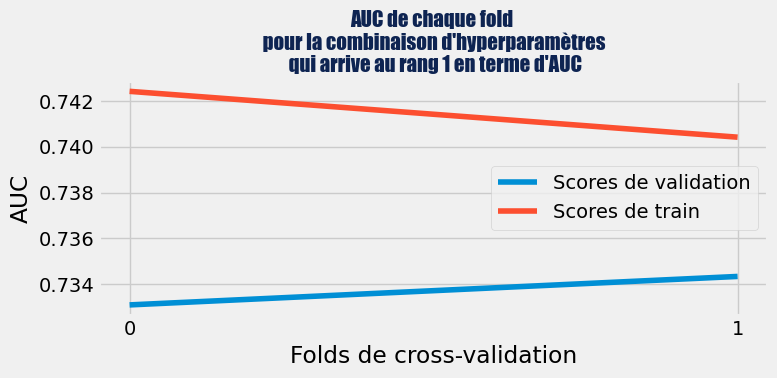

In [74]:
plot_auc_scores(best_auc_result)

R√©sultats proches d'un fold √† l'autre

### 4.5.4 - Pr√©dictions et m√©triques d'√©valuation

Cr√©ation d'une fonction qui va √©valuer le mod√®le sur les donn√©es d'entrainement et sur les donn√©es de test, en calculant diff√©retes m√©triques

In [75]:
def evaluate_model(X_train, y_train, X_test, y_test, best_model):
    """
    √âvalue le mod√®le de classification sur les ensembles de donn√©es d'entra√Ænement et de test,
    en calculant diverses m√©triques de performance et en d√©terminant le seuil optimal bas√© sur une fonction de co√ªt.

    Param√®tres :
    -----------
    X_train : array-like
        Les caract√©ristiques d'entra√Ænement.
    
    y_train : array-like
        Les √©tiquettes d'entra√Ænement.
    
    X_test : array-like
        Les caract√©ristiques de test.
    
    y_test : array-like
        Les √©tiquettes de test.
    
    best_model : estimator
        Le meilleur mod√®le estim√© obtenu apr√®s la recherche en grille.

    Retourne :
    --------
    dict
        Un dictionnaire contenant les m√©triques suivantes :
        - 'predicting_execution_time' : le temps d'ex√©cution pour les pr√©dictions.
        - 'auc_train' : l'AUC sur les donn√©es d'entra√Ænement.
        - 'auc_test' : l'AUC sur les donn√©es de test.
        - 'optimal_threshold' : le seuil optimal pour la fonction de co√ªt.
        - 'f1_score_1_test' : le F1 score sur les donn√©es de test au seuil optimal.
        - 'recall_1_test' : le rappel sur les donn√©es de test au seuil optimal.
        - 'accuracy_test' : l'exactitude sur les donn√©es de test au seuil optimal.

    Description :
    ------------
    Cette fonction pr√©dit les probabilit√©s pour les ensembles de donn√©es d'entra√Ænement et de test, 
    calcule l'AUC pour les deux ensembles, trouve le seuil optimal bas√© sur une fonction de co√ªt personnalis√©e 
    (faux n√©gatifs co√ªtant 10 unit√©s et faux positifs co√ªtant 1 unit√©), et calcule les m√©triques de performance 
    (F1 score, rappel, exactitude) au seuil optimal.

    Exemple :
    --------
    >>> results = evaluate_model(X_train, y_train, X_test, y_test, best_model)
    >>> print(results['auc_test'])
    0.85

    """
    start_predict_time = time.time()
    # Pr√©dire sur les donn√©es d'entra√Ænement
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Pr√©dire sur les donn√©es de test
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculer l'AUC pour les donn√©es d'entra√Ænement et de test
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba), 2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba), 2)

    # Trouver le seuil optimal pour la fonction de co√ªt sur les donn√©es d'entra√Ænement
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)], 2) 

    # M√©triques au seuil optimal
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test, 2),
        'recall_1_test': round(recall_1_test, 2),
        'accuracy_test': round(accuracy_test, 2)
    }


In [76]:
result_logit=evaluate_model (X_train_sc, y_train, X_test_sc, y_test, best_model_logit)
result_logit

{'predicting_execution_time': 0.1,
 'auc_train': 0.74,
 'auc_test': 0.74,
 'optimal_threshold': 0.51,
 'f1_score_1_test': 0.26,
 'recall_1_test': 0.64,
 'accuracy_test': 0.7}

- La RegLog performe bcp mieux que le mod√®le na√Øf, avec une AUC sur le train et sur le test de 0.74 => ce qui veut dire que le mod√®le a une bonne capacit√© discriminante. Il peut distinguer correctement les classes positives et n√©gatives 74% du temps.
- Le fait que l'AUC soit similaire pour les donn√©es d'entra√Ænement et de test sugg√®re que le mod√®le g√©n√©ralise bien. Il n'y a pas de signe de surapprentissage (overfitting) ni de sous-apprentissage (underfitting).
- Le seuil optimal qui permet de minimiser le co√ªt m√©tier est de 0.51
- A ce seuil optimal de 0.51, le recall de la classe 1 monte √† 0.64 => cela signifie que le mod√®le d√©tecte correctement 64% des instances de la classe 1. Ce rappel est raisonnablement bon, mais il y a encore 36% des instances de la classe 1 qui ne sont pas d√©tect√©es (faux n√©gatifs).

### 4.5.5 - Enregistrement du mod√®le dans ML Flow

In [77]:
# Utiliser un √©chantillon de 10 lignes comme exemple d'entr√©e
input_example = X_train_sc.sample(n=10, random_state=42)

In [78]:
# # Cr√©ation d'une nouvelle exp√©rience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai d√©clar√©s au dessus
#     mlflow.log_params(best_params_logit)

#     # Log les m√©triques
    
#     mlflow.log_metric("optimal_threshold", result_logit['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_logit['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_logit['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_logit['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_logit['auc_train'])
#     mlflow.log_metric("auc_test", result_logit['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_logit['predicting_execution_time'])

      

#     # D√©finir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Logistic Regression with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_logit.predict(X_train_sc)) # infer_signature g√©n√®re automatiquement une "signature" 
#                                                               # qui d√©crit les entr√©es et les sorties du mod√®le. 
#                                                               # Cela inclut les types de donn√©es et les formats attendus par le mod√®le, 
#                                                               # facilitant ainsi l'int√©gration et la r√©utilisation du mod√®le 
#                                                               # dans diff√©rents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_logit.named_steps['model'], # le mod√®le
#         artifact_path="logistic_regression_model", # le chemin o√π le mod√®le sera enregistr√©
#         signature=signature, # la signature du mod√®le
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le mod√®le
#         registered_model_name="scoring-credit-logistic-regression", # nom sous lequel le mod√®le est enregistr√© dans le registre de mod√®les MLflow
#     )


### 4.5.6 - Feature Importance

In [79]:
importances = best_model_logit.named_steps['model'].coef_
importances = importances.flatten()

In [80]:
feature_importances = pd.DataFrame({
    'feature': X_train_sc.columns, 
    'importance': importances
})

In [81]:
feature_importances_sorted=feature_importances.sort_values(by='importance', ascending=False).reset_index()
feature_importances_sorted=feature_importances_sorted.head(10)

In [82]:
feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()

In [83]:
feature_importances_sorted

index                           feature  importance  importance_normalized
0      5                        AMT_CREDIT   10.635820               0.239954
1     77          DEF_30_CNT_SOCIAL_CIRCLE    5.560673               0.125454
2     51                   COMMONAREA_MODE    5.109357               0.115272
3     81                   FLAG_DOCUMENT_2    4.570375               0.103112
4     71             LIVINGAPARTMENTS_MEDI    3.818498               0.086149
5     62                 BASEMENTAREA_MEDI    3.178713               0.071715
6     35       YEARS_BEGINEXPLUATATION_AVG    3.042854               0.068650
7     46                 NONLIVINGAREA_AVG    2.874495               0.064851
8    120  NAME_INCOME_TYPE_Maternity leave    2.779584               0.062710
9     52                    ELEVATORS_MODE    2.754067               0.062134

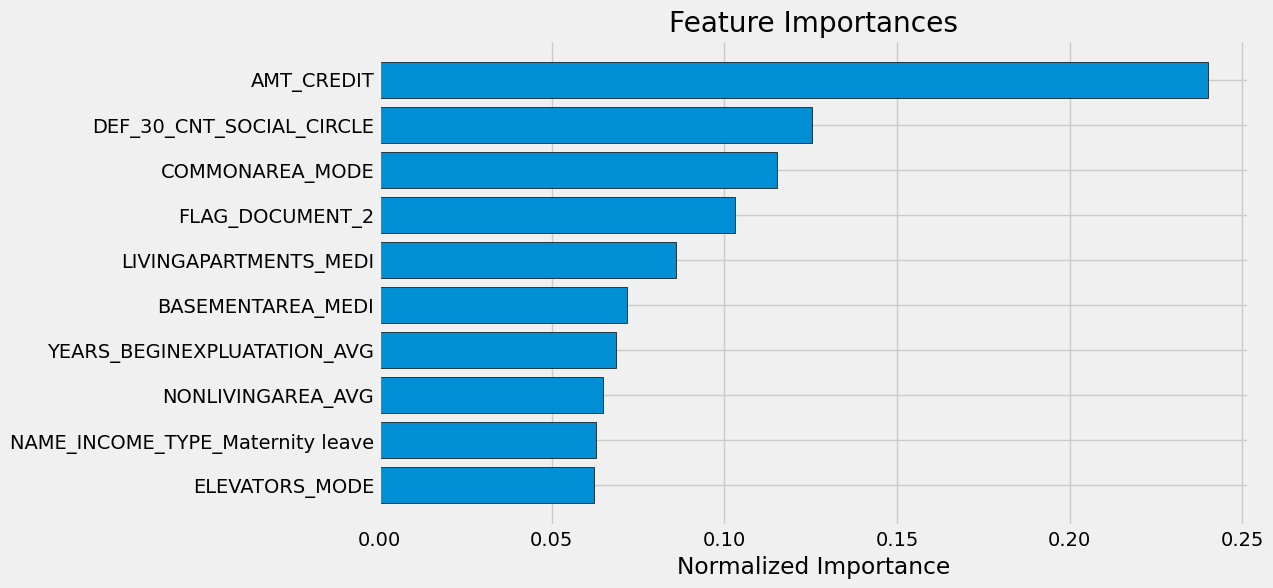

In [84]:
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_sorted.index[:15]))), 
feature_importances_sorted['importance_normalized'].head(15), 
align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_sorted.index[:15]))))
ax.set_yticklabels(feature_importances_sorted['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

Les 3 premi√®res variables les + importantes pour le mod√®le :
- 'AMT_CREDIT' =	Montant du pr√™t
- 'DEF_30_CNT_SOCIAL_CIRCLE' = nombre d'occasions o√π les entourages sociaux du client ont √©t√© enregistr√©s comme ayant un retard de paiement exactement de 30 jours apr√®s la date d'√©ch√©ance.
- 'COMMONAREA_MODE' = Informations normalis√©es sur l'immeuble o√π vit le client : taille moyenne (suffixe _AVG), modus (suffixe _MODE), m√©diane (suffixe _MEDI) de l'appartement, surface commune, surface habitable, √¢ge de l'immeuble, nombre d'ascenseurs, nombre d'entr√©es, √©tat de l'immeuble, nombre d'√©tages, etc.


Nous allons maintenant comparer avec une random forest

## 4.6 - Random Forest

###  4.6.1 - Entrainement

In [85]:
model_RF = RandomForestClassifier(random_state = 50, 
                                  class_weight='balanced')
param_grid_RF = {
   'n_estimators': [120,150],  
   'max_depth': [7,8],
   # 'max_features': [0.0],
   # 'min_samples_leaf': [0.01,0.05],
   # 'min_samples_split': [0.03,0.05]
    
}

NOTES :
- **n_estimators** est le nombre d'arbres de d√©cision que la for√™t al√©atoire va entra√Æner.
- **max_depth** est la profondeur maximale que chaque arbre de d√©cision dans la for√™t peut atteindre.

In [86]:
# Execution de la fonction
start_training_time = time.time()

results_RF = run_grid_search(X_train_sc, y_train, model_RF, param_grid_RF)

end_training_time = time.time()

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__max_depth=7, model__n_estimators=120; AUC: (train=0.678, test=0.667) F1_opt: (train=0.216, test=0.214) recall_opt: (train=0.622, test=0.580) total time=  39.1s
[CV 2/2] END model__max_depth=7, model__n_estimators=120; AUC: (train=0.680, test=0.659) F1_opt: (train=0.216, test=0.209) recall_opt: (train=0.639, test=0.546) total time=  39.1s
[CV 1/2] END model__max_depth=7, model__n_estimators=150; AUC: (train=0.679, test=0.668) F1_opt: (train=0.214, test=0.217) recall_opt: (train=0.657, test=0.546) total time=  47.5s
[CV 2/2] END model__max_depth=7, model__n_estimators=150; AUC: (train=0.679, test=0.659) F1_opt: (train=0.217, test=0.210) recall_opt: (train=0.608, test=0.517) total time=  48.2s
[CV 1/2] END model__max_depth=8, model__n_estimators=120; AUC: (train=0.691, test=0.670) F1_opt: (train=0.221, test=0.213) recall_opt: (train=0.646, test=0.622) total time=  43.9s
[CV 2/2] END model__max_depth=8, model__n

In [87]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'ex√©cution est de {training_execution_time} secondes.")

Le temps d'ex√©cution est de 515.79 secondes.


In [88]:
best_model_RF = results_RF['best_model']
best_params_RF = results_RF['best_params_']
best_score_RF = results_RF['best_score_']
cv_results_RF = results_RF['cv_results_']

print("Best Params:", best_params_RF)
print("Best AUC:", best_score_RF)

Best Params: {'model__max_depth': 8, 'model__n_estimators': 150}
Best AUC: 0.6658718718108061


La meilleure AUC est obtenu avec 150 arbres d'une profondeur de 8

###  2.3.2 - Analyse de la cross_validation

In [89]:
best_auc_result_RF = extract_best_auc_result(results_RF)
best_auc_result_RF.head(1)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3      47.643001      0.075283         5.487022        0.069238   

   param_model__max_depth  param_model__n_estimators  \
3                       8                        150   

                                              params  split0_test_AUC  \
3  {'model__max_depth': 8, 'model__n_estimators':...         0.670432   

   split1_test_AUC  mean_test_AUC  std_test_AUC  rank_test_AUC  \
3         0.661312       0.665872       0.00456              1   

   split0_train_AUC  split1_train_AUC  mean_train_AUC  std_train_AUC  \
3          0.690682          0.691043        0.690862        0.00018   

   split0_test_F1_opt  split1_test_F1_opt  mean_test_F1_opt  std_test_F1_opt  \
3            0.213935            0.209778          0.211856         0.002078   

   rank_test_F1_opt  split0_train_F1_opt  split1_train_F1_opt  \
3                 3             0.220787              0.22354   

   mean_train_F1_opt  std_train_F1_opt  split0_test_recall_opt  \
3           0.222164          0.001376                0.591366   

   split1_test_recall_opt  mean_test_recall_opt  std_test_recall_opt  \
3                0.578788              0.585077             0.006289   

   rank_test_recall_opt  split0_train_recall_opt  split1_train_recall_opt  \
3                     1                  0.64681                  0.61451   

   mean_train_recall_opt  std_train_recall_opt  
3                0.63066               0.01615

In [90]:
# Les r√©sultats de la combinaison la mieux class√©e
best_auc_result_RF.iloc[0]

mean_fit_time                                                        47.643001
std_fit_time                                                          0.075283
mean_score_time                                                       5.487022
std_score_time                                                        0.069238
param_model__max_depth                                                       8
param_model__n_estimators                                                  150
params                       {'model__max_depth': 8, 'model__n_estimators':...
split0_test_AUC                                                       0.670432
split1_test_AUC                                                       0.661312
mean_test_AUC                                                         0.665872
std_test_AUC                                                           0.00456
rank_test_AUC                                                                1
split0_train_AUC                                    

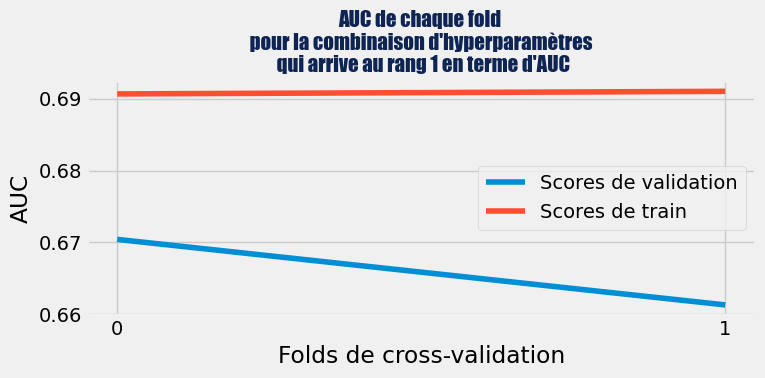

In [91]:
plot_auc_scores(best_auc_result_RF)

###  2.3.3 - Pr√©dictions et m√©triques d'√©valuation

In [92]:
result_RF=evaluate_model(X_train_sc, y_train, X_test_sc, y_test, best_model_RF)
result_RF

{'predicting_execution_time': 2.83,
 'auc_train': 0.68,
 'auc_test': 0.67,
 'optimal_threshold': 0.39,
 'f1_score_1_test': 0.21,
 'recall_1_test': 0.61,
 'accuracy_test': 0.63}

- Ces valeurs montrent que le RF a une performance raisonnable mais pas excellente. Une AUC autour de 0.67-0.68 indique que le mod√®le est capable de distinguer les classes positives et n√©gatives environ 67-68% du temps (contre 74% avec la RegLog).
- Le fait que les AUC soient similaires pour l'entra√Ænement et le test sugg√®re que le mod√®le g√©n√©ralise bien et n'est pas surappris (overfitting).
- Le seuil optimal de 0.39 est celui qui minimise une fonction de co√ªt sp√©cifique (faux n√©gatifs co√ªtant 10 unit√©s et faux positifs co√ªtant 1 unit√©, comme indiqu√© dans la fonction calculate_cost_threshold)
- Un rappel de 0.61 signifie que le mod√®le d√©tecte correctement 61% des instances de la classe 1.
Cela indique que le mod√®le rate encore 39% des instances positives (faux n√©gatifs). Bien que ce rappel soit mod√©r√©ment bon, il y a encore une marge d'am√©lioration.

### 2.3.4 - Enregistrement dans ML Flow

In [93]:
# # Cr√©ation d'une nouvelle exp√©rience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai d√©clar√©s au dessus
#     mlflow.log_params(best_params_RF)

#     # Log les m√©triques
    
#     mlflow.log_metric("optimal_threshold", result_RF['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_RF['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_RF['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_RF['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_RF['auc_train'])
#     mlflow.log_metric("auc_test", result_RF['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_RF['predicting_execution_time'])

    
 
    

#     # D√©finir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Random forest Classifier with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_RF.predict(X_train_sc)) # infer_signature g√©n√®re automatiquement une "signature" 
#                                                               # qui d√©crit les entr√©es et les sorties du mod√®le. 
#                                                               # Cela inclut les types de donn√©es et les formats attendus par le mod√®le, 
#                                                               # facilitant ainsi l'int√©gration et la r√©utilisation du mod√®le 
#                                                               # dans diff√©rents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_RF.named_steps['model'], # le mod√®le
#         artifact_path="random_forest_classifier_model", # le chemin o√π le mod√®le sera enregistr√©
#         signature=signature, # la signature du mod√®le
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le mod√®le
#         registered_model_name="scoring-credit-random-forest_classifier", # nom sous lequel le mod√®le est enregistr√© dans le registre de mod√®les MLflow
#     )


### 2.3.5 - Feature Importance

In [94]:
importances = best_model_RF.named_steps['model'].feature_importances_
features= X_train_sc.columns

In [95]:
def show_feature_importances(importances, features):
    """
    Affiche les importances des caract√©ristiques sous forme de graphique √† barres horizontales
    et retourne les 10 caract√©ristiques les plus importantes tri√©es par importance.

    Param√®tres :
    -----------
    importances : array-like
        Les valeurs d'importance des caract√©ristiques. Elles doivent √™tre de type numpy array ou similaire.
    
    features : array-like
        Les noms des caract√©ristiques correspondantes aux importances. Elles doivent √™tre de type liste ou similaire.

    Retourne :
    --------
    DataFrame
        Un DataFrame contenant les 10 caract√©ristiques les plus importantes, leur importance brute et leur importance normalis√©e.

    Description :
    ------------
    Cette fonction cr√©e un DataFrame des importances des caract√©ristiques et les trie par ordre d√©croissant d'importance.
    Elle s√©lectionne les 10 caract√©ristiques les plus importantes et normalise leurs importances. Ensuite, elle affiche
    un graphique √† barres horizontales des importances normalis√©es pour ces 10 caract√©ristiques principales.

    Exemple :
    --------
    >>> importances = [0.15, 0.10, 0.05, 0.20, 0.50]
    >>> features = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5']
    >>> feature_importances_sorted = show_feature_importances(importances, features)
    >>> print(feature_importances_sorted)
         feature  importance  importance_normalized
    0  feature5        0.50                   0.50
    1  feature4        0.20                   0.20
    2  feature1        0.15                   0.15
    3  feature2        0.10                   0.10
    4  feature3        0.05                   0.05

    """
    # Cr√©ation du DataFrame
    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et s√©lection des 10 caract√©ristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(10)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Cr√©ation du graphique √† barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # D√©finition des √©tiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # √âtiquetage du graphique
    plt.xlabel('Normalized Importance')
    plt.title('Top 10 Feature Importances')
    plt.show()
    
    return feature_importances_sorted


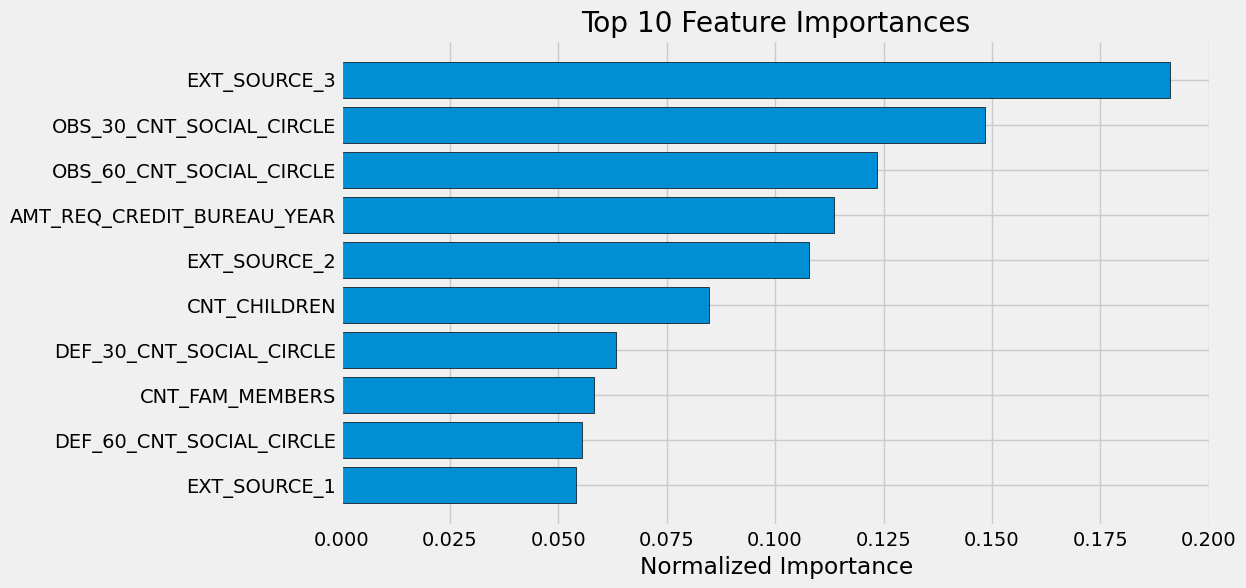

feature  importance  importance_normalized
0                EXT_SOURCE_3    0.117288               0.190987
1    OBS_30_CNT_SOCIAL_CIRCLE    0.091057               0.148273
2    OBS_60_CNT_SOCIAL_CIRCLE    0.075811               0.123447
3  AMT_REQ_CREDIT_BUREAU_YEAR    0.069761               0.113597
4                EXT_SOURCE_2    0.066215               0.107822
5                CNT_CHILDREN    0.052067               0.084784
6    DEF_30_CNT_SOCIAL_CIRCLE    0.038883               0.063316
7             CNT_FAM_MEMBERS    0.035777               0.058257
8    DEF_60_CNT_SOCIAL_CIRCLE    0.034075               0.055486
9                EXT_SOURCE_1    0.033181               0.054031

In [96]:
show_feature_importances(importances, features)

Les 3 variables les + influentes :
- 'EXT_SOURCE_3' : variable de score normalis√© provenant d'une source de donn√©es externe
- 'OBS_30_CNT_SOCIAL_CIRCLE' :  nombre d'observations o√π l'on peut constater que les entourages sociaux du client ont des d√©fauts de paiement d√©passant 30 jours apr√®s l'√©ch√©ance pr√©vue.
- - 'OBS_60_CNT_SOCIAL_CIRCLE' :  nombre d'observations o√π l'on peut constater que les entourages sociaux du client ont des d√©fauts de paiement d√©passant 60 jours apr√®s l'√©ch√©ance pr√©vue.

Les variables qui ont le plus de poids dans le Random Forest sont tr√®s diff√©rentes de la Regression logistique

## 4.7 - Light Gradient Boosting Machine

LightGBM est un framework d'apprentissage automatique d√©velopp√© par Microsoft, qui est largement utilis√© pour les t√¢ches de classification, de r√©gression et de classement. Il appartient √† la cat√©gorie des algorithmes de boosting bas√©s sur des arbres de d√©cision, similaire √† XGBoost et CatBoost.   

Voici quelques points cl√©s pour comprendre LightGBM :

LightGBM utilise le gradient boosting, une technique qui construit de mani√®re it√©rative des mod√®les de pr√©vision en ajoutant des arbres de d√©cision faibles, chaque nouvel arbre √©tant construit pour corriger les erreurs des arbres pr√©c√©dents. Ces arbres sont ajout√©s s√©quentiellement jusqu'√† ce qu'un nombre sp√©cifi√© d'arbres soit atteint ou que les am√©liorations deviennent n√©gligeables.

**Son fonctionnement** :
1. Initialisation 
- LightGBM commence par cr√©er un mod√®le initial tr√®s simple, souvent appel√© "base learner". Ce mod√®le peut √™tre quelque chose d‚Äôaussi simple qu‚Äôune r√©gression ou un arbre de d√©cision tr√®s basique. L'id√©e est de cr√©er un point de d√©part pour l'algorithme.
- Ce premier mod√®le fait une pr√©diction basique qui est g√©n√©ralement loin d'√™tre parfaite mais fournit une base sur laquelle construire.

2. Apprendre des Erreurs
- Apr√®s avoir fait ses premi√®res pr√©dictions, LightGBM examine les erreurs ‚Äî les diff√©rences entre les valeurs pr√©dites et les valeurs r√©elles. Ces erreurs sont aussi appel√©es r√©sidus.
- Un nouveau mod√®le est ensuite entra√Æn√©, mais au lieu de pr√©dire la valeur cible originale, il essaie de pr√©dire ces r√©sidus (les erreurs du premier mod√®le). L‚Äôid√©e est de corriger l√† o√π le premier mod√®le s‚Äôest tromp√©.

3. R√©p√©ter
- Ce processus de correction des erreurs en entra√Ænant un nouveau mod√®le sur les r√©sidus est r√©p√©t√© plusieurs fois. Chaque nouveau mod√®le est con√ßu pour am√©liorer les pr√©dictions l√† o√π les mod√®les pr√©c√©dents ont √©chou√©.
- √Ä chaque √©tape, l‚Äôalgorithme se concentre de plus en plus sur les cas les plus difficiles √† pr√©dire, raffinant progressivement sa capacit√© √† mod√©liser les donn√©es de mani√®re pr√©cise.

4. Combiner
- Tous les mod√®les simples cr√©√©s lors des diff√©rentes it√©rations sont combin√©s pour former le mod√®le final. Chaque mod√®le individuel apporte sa contribution sp√©cifique, aidant √† pr√©dire une partie diff√©rente du probl√®me.
- Dans LightGBM, comme dans d'autres algorithmes de boosting, les contributions de chaque mod√®le peuvent √™tre pond√©r√©es pour optimiser les performances globales. Certains mod√®les peuvent se voir attribuer plus d'importance en fonction de leur pr√©cision.

**Particularit√©s du LightGBM**
- Contrairement √† d'autres algorithmes qui construisent des arbres en se d√©veloppant niveau par niveau, LightGBM utilise une strat√©gie de croissance par feuilles. Dans cette approche, plut√¥t que d'ajouter une rang√©e compl√®te de branches, vous ajoutez la branche la plus n√©cessaire ou la plus "utile" √† chaque √©tape, ind√©pendamment du niveau. Cela permet de se concentrer plus intens√©ment sur les parties de l'arbre qui r√©duiront le plus rapidement l'erreur globale. Cela permet souvent de r√©duire plus rapidement l'erreur globale, bien que le risque de surajustement puisse √™tre l√©g√®rement plus √©lev√©, surtout avec des ensembles de donn√©es plus petits.
- LightGBM utilise des techniques telles que le partage bas√© sur des histogrammes pour acc√©l√©rer l'entra√Ænement. Au lieu de regarder chaque point de donn√©e unique, il regroupe les valeurs en "bacs" (comme les barres d'un histogramme), et ces bacs sont utilis√©s pour trouver le meilleur endroit pour diviser les donn√©es. Cette m√©thode r√©duit consid√©rablement le nombre de calculs n√©cessaires, car il y a moins de points de division √† consid√©rer. Cela rend l'algorithme beaucoup plus rapide et moins gourmand en m√©moire, particuli√®rement avantageux quand on travaille avec de grands ensembles de donn√©es.

En r√©sum√©, LightGBB utilise une s√©rie de mod√®les qui apprennent progressivement des erreurs des mod√®les pr√©c√©dents, chacun ajoutant sa propre correction jusqu'√† ce qu'un mod√®le final complet et pr√©cis soit form√©. C'est une m√©thode puissante car elle transforme de nombreux apprenants faibles en un pr√©dicteur fort et fiable.

**Avantages** :
- Vitesse et efficacit√© : L'une des principales forces de LightGBM est sa vitesse d'entra√Ænement rapide et son utilisation efficace de la m√©moire.
- Prise en charge des donn√©es cat√©gorielles : LightGBM peut g√©rer directement les caract√©ristiques cat√©gorielles sans n√©cessiter de codage pr√©alable, ce qui est une diff√©rence significative par rapport √† d'autres algorithmes de boosting.
- Facilit√© d'utilisation et flexibilit√© : Il est facile √† configurer avec une large gamme de param√®tres ajustables pour optimiser les performances du mod√®le.
  
**Applications** :
- LightGBM est utilis√© dans une vari√©t√© de domaines allant de la pr√©diction de risques financiers √† la d√©tection de fraudes, en passant par les recommandations de produits et la pr√©diction de demandes. Sa capacit√© √† fournir des r√©sultats rapides et pr√©cis avec des ensembles de donn√©es volumineux le rend particuli√®rement pr√©cieux dans les environnements o√π les performances et la vitesse sont critiques.



**Quelle diff√©rence avec XGboost ?**
LightGBM et XGBoost sont deux des frameworks les plus populaires pour le boosting d'arbres de d√©cision, mais ils pr√©sentent des diff√©rences cl√©s en termes de m√©thodologie, d'optimisation, et d'applications typiques. Voici une comparaison des deux, ainsi que les d√©tails sur leur apparition :

XGBoost (eXtreme Gradient Boosting)
Apparition: XGBoost a √©t√© d√©velopp√© par Tianqi Chen dans le cadre d'un projet de recherche √† l'Universit√© de Washington et a √©t√© rendu public en 2014. Il a rapidement gagn√© en popularit√© en raison de sa performance dans de nombreuses comp√©titions de machine learning.

Caract√©ristiques:
- Utilise un mod√®le de boosting de gradient, construisant des arbres de mani√®re s√©quentielle.
- Employe un algorithme bas√© sur le pr√©-partitionnement des donn√©es en structure de bloc pour g√©rer les grands ensembles de donn√©es de mani√®re plus efficace.
- Propose des r√©gularisations (L1 et L2) pour pr√©venir le surajustement.
- Utilise la croissance par niveaux des arbres (level-wise), qui √©quilibre mieux la croissance des arbres mais peut √™tre moins efficace en termes de r√©duction de l'erreur par rapport √† la croissance par feuilles.

LightGBM
Apparition: LightGBM a √©t√© d√©velopp√© par Microsoft et introduit en janvier 2017. Il a √©t√© con√ßu pour surmonter certaines des limitations de vitesse et d'√©chelle de XGBoost et d'autres algorithmes de boosting.

Caract√©ristiques:
- Utilise √©galement le boosting de gradient mais incorpore plusieurs optimisations pour la vitesse et l'efficacit√©, comme le partage bas√© sur des histogrammes.
- Utilise la croissance par feuilles (leaf-wise) qui peut r√©duire l'erreur plus rapidement mais risque le surajustement sur des petits ensembles de donn√©es.
- G√®re efficacement les donn√©es cat√©gorielles sans pr√©traitement.
- Optimis√© pour la performance en vitesse et en utilisation de m√©moire, particuli√®rement sur des ensembles de donn√©es de grande taille.

Diff√©rences Cl√©s
- M√©thode de construction des arbres : XGBoost construit les arbres niveau par niveau tandis que LightGBM le fait feuille par feuille.
- Gestion des caract√©ristiques cat√©gorielles : LightGBM peut g√©rer directement les caract√©ristiques cat√©gorielles, alors que XGBoost n√©cessite g√©n√©ralement un pr√©traitement comme le one-hot encoding.
- Efficacit√© et vitesse : LightGBM est g√©n√©ralement plus rapide qu'XGBoost, en particulier sur des ensembles de donn√©es tr√®s grands ou avec de nombreuses caract√©ristiques, en raison de ses optimisations sp√©cifiques.

Choix entre les deux
Le choix entre XGBoost et LightGBM d√©pend souvent de la taille de l'ensemble de donn√©es et des ressources disponibles :
- XGBoost peut √™tre pr√©f√©rable pour des ensembles de donn√©es de taille mod√©r√©e ou lorsque la pr√©vention du surajustement est critique.
- LightGBM est souvent le choix pour des ensembles de donn√©es tr√®s volumineux ou pour des applications n√©cessitant une grande efficacit√© de calcul.

Dans l'ensemble, les deux frameworks sont hautement performants et le choix entre eux peut aussi d√©pendre de la familiarit√© et des pr√©f√©rences personnelles des utilisateurs en mati√®re d'outils d'apprentissage automatique.

### 4.7.1 - Entrainement

In [97]:
model_LGBM = lgb.LGBMClassifier(objective='binary', # sp√©cifie que le mod√®le est utilis√© pour une classification binaire
                                boosting_type = 'goss',# boosting_type d√©termine l'algorithme de boosting √† utiliser. 
                                                   # GOSS signifie Gradient-based One-Side Sampling. 
                                                   # GOSS est une m√©thode avanc√©e qui am√©liore l'efficacit√© du mod√®le en conservant toutes les instances
                                                   # avec des gradients importants (ceux qui sont mal pr√©dits) 
                                                   # et en sous-√©chantillonnant de mani√®re al√©atoire les instances avec des gradients faibles 
                                                   # (ceux qui sont bien pr√©dits). 
                                                   # Cette technique permet de r√©duire la quantit√© de donn√©es tout en conservant 
                                                   # les informations les plus utiles pour l'apprentissage, 
                                                   # acc√©l√©rant ainsi la formation sans perte significative de pr√©cision.

                                class_weight='balanced',
                                random_state = 50)
        
param_grid_LGBM = {
    'num_leaves': [20,25],
    # 'learning_rate' : [0.01,0.1], 
    'n_estimators': [100,200]
}

# Param√®tres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks':[early_stopping(stopping_rounds=50)]
}

- num_leaves : d√©finit le nombre maximal de feuilles (n≈ìuds terminaux) qu'un arbre peut avoir. Cela d√©termine la complexit√© et la capacit√© d'apprentissage de chaque arbre individuel. Par d√©faut 31
- learning_rate : contr√¥le la vitesse √† laquelle le mod√®le apprend. Un taux d'apprentissage, ou learning rate, plus bas signifie que le mod√®le mettra plus de temps √† converger vers une solution optimale, mais cela peut aussi aider √† √©viter le surapprentissage en faisant des pas plus prudents pendant l'entra√Ænement. Par d√©faut =0.1
- n_estimators = le nombre d'arbres √† construire dans le mod√®le. par d√©faut =100

In [98]:
X_train_sc.columns= [col.replace('{', '').replace('}', '').replace(':', '').replace('[', '').replace(']', '').replace(',', '').replace('"', '').replace("'", '') for col in X_train_sc.columns]

In [99]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM = run_grid_search(X_train_sc, y_train, model_LGBM, param_grid_LGBM,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49912
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 233
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]

In [100]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'ex√©cution est de {training_execution_time} secondes.")

Le temps d'ex√©cution est de 144.01 secondes.


In [101]:
best_model_lgbm = results_LGBM['best_model']
best_params_lgbm = results_LGBM['best_params_']
best_score_lgbm = results_LGBM['best_score_']
cv_results_lgbm = results_LGBM['cv_results_']

print("Best Params:", best_params_lgbm)
print("Best AUC:", best_score_lgbm)

Best Params: {'model__n_estimators': 200, 'model__num_leaves': 20}
Best AUC: 0.744016306189205


### 2.4.2 - Analyse de la cross_validation

In [102]:
best_auc_result_LGBM = extract_best_auc_result(results_LGBM)
best_auc_result_LGBM.head(1)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       6.597847      0.013682         5.737425         0.11117   

   param_model__n_estimators  param_model__num_leaves  \
2                        200                       20   

                                              params  split0_test_AUC  \
2  {'model__n_estimators': 200, 'model__num_leave...         0.744708   

   split1_test_AUC  mean_test_AUC  std_test_AUC  rank_test_AUC  \
2         0.743324       0.744016      0.000692              1   

   split0_train_AUC  split1_train_AUC  mean_train_AUC  std_train_AUC  \
2          0.800159          0.804228        0.802193       0.002034   

   split0_test_F1_opt  split1_test_F1_opt  mean_test_F1_opt  std_test_F1_opt  \
2            0.268105            0.258692          0.263399         0.004706   

   rank_test_F1_opt  split0_train_F1_opt  split1_train_F1_opt  \
2                 2             0.305994             0.306559   

   mean_train_F1_opt  std_train_F1_opt  split0_test_recall_opt  \
2           0.306276          0.000282                 0.62266   

   split1_test_recall_opt  mean_test_recall_opt  std_test_recall_opt  \
2                0.660696              0.641678             0.019018   

   rank_test_recall_opt  split0_train_recall_opt  split1_train_recall_opt  \
2                     1                 0.705575                 0.713725   

   mean_train_recall_opt  std_train_recall_opt  
2                0.70965              0.004075

In [103]:
# Les r√©sultats de la combinaison la mieux class√©e
best_auc_result_LGBM.iloc[0]

mean_fit_time                                                         6.597847
std_fit_time                                                          0.013682
mean_score_time                                                       5.737425
std_score_time                                                         0.11117
param_model__n_estimators                                                  200
param_model__num_leaves                                                     20
params                       {'model__n_estimators': 200, 'model__num_leave...
split0_test_AUC                                                       0.744708
split1_test_AUC                                                       0.743324
mean_test_AUC                                                         0.744016
std_test_AUC                                                          0.000692
rank_test_AUC                                                                1
split0_train_AUC                                    

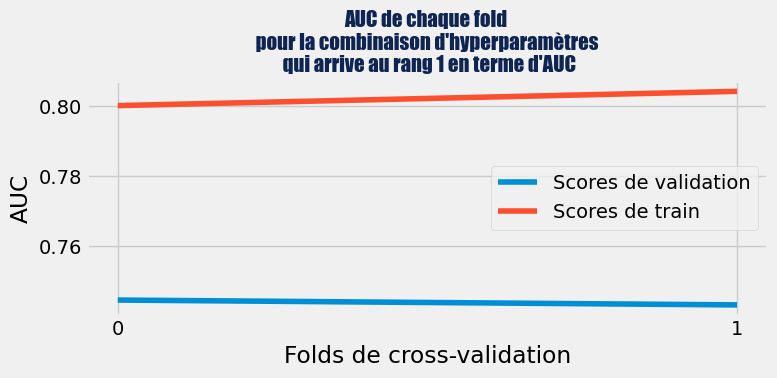

In [104]:
plot_auc_scores(best_auc_result_LGBM)

### 2.4.3 - Pr√©dictions et m√©triques d'√©valuation

In [105]:
result_lgbm=evaluate_model (X_train_sc, y_train, X_test_sc, y_test, best_model_lgbm)
result_lgbm

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 0.72,
 'auc_train': 0.78,
 'auc_test': 0.75,
 'optimal_threshold': 0.1,
 'f1_score_1_test': 0.27,
 'recall_1_test': 0.63,
 'accuracy_test': 0.73}

- Une AUC de 0.78 sur le train et 0.75 sur le test signifie que le mod√®le a une bonne capacit√© de discrimination entre les bons et les mauvais clients avec un l√©ger overfitting qui reste acceptable
- Le seuil optimal de 0.1 est celui qui minimise une fonction de co√ªt sp√©cifique (faux n√©gatifs co√ªtant 10 unit√©s et faux positifs co√ªtant 1 unit√©, comme indiqu√© dans la fonction calculate_cost_threshold)
- Un rappel de 0.63 signifie que le mod√®le d√©tecte correctement 63% des instances de la classe 1.
Cela indique que le mod√®le rate encore 37% des instances positives (faux n√©gatifs). Bien que ce rappel soit mod√©r√©ment bon, il y a encore une marge d'am√©lioration. Le recall de la RegLog est meilleur d'un point

### 2.4.4 - Enregistrement dans ML Flow

In [106]:
# Cr√©ation d'une nouvelle exp√©rience MLflow
mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# Commencer une session MLflow
with mlflow.start_run():
    # Log les hyperparameters que j'ai d√©clar√©s au dessus
    mlflow.log_params(best_params_lgbm)

    # Log les m√©triques
    
    mlflow.log_metric("optimal_threshold", result_lgbm['optimal_threshold'])

    mlflow.log_metric("recall_1_test", result_lgbm['recall_1_test'])
    mlflow.log_metric("f1_score_1_test", result_lgbm['f1_score_1_test'])
    mlflow.log_metric("accuracy du test", result_lgbm['accuracy_test'])
    
    mlflow.log_metric("auc_train", result_lgbm['auc_train'])
    mlflow.log_metric("auc_test", result_lgbm['auc_test'])
    
    mlflow.log_metric("temps_fit", training_execution_time)
    mlflow.log_metric("temps_predict", result_lgbm['predicting_execution_time'])

    
 
    

    # D√©finir un tag pour se rappeler l'objet de cette session
    mlflow.set_tag("Training Info", "LGBM with GridSearchCV ")

    # Infer the model signature
    signature = infer_signature(X_train_sc, best_model_lgbm.predict(X_train_sc)) # infer_signature g√©n√®re automatiquement une "signature" 
                                                              # qui d√©crit les entr√©es et les sorties du mod√®le. 
                                                              # Cela inclut les types de donn√©es et les formats attendus par le mod√®le, 
                                                              # facilitant ainsi l'int√©gration et la r√©utilisation du mod√®le 
                                                              # dans diff√©rents environnements.

    
    # Log le model
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model_lgbm.named_steps['model'], # le mod√®le
        artifact_path="lgbm_classifier_model", # le chemin o√π le mod√®le sera enregistr√©
        signature=signature, # la signature du mod√®le
        input_example=input_example, # un exemple d'input pour montrer comment invoquer le mod√®le
        registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le mod√®le est enregistr√© dans le registre de mod√®les MLflow
    )


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Registered model 'scoring-credit-lgbm_classifier' already exists. Creating a new version of this model...
2024/07/24 23:02:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: scoring-credit-lgbm_classifier, version 28
Created version '28' of model 'scoring-credit-lgbm_classifier'.


### 2.4.5 - Feature importance

In [107]:
importances = best_model_lgbm.named_steps['model'].feature_importances_
features= X_train_sc.columns

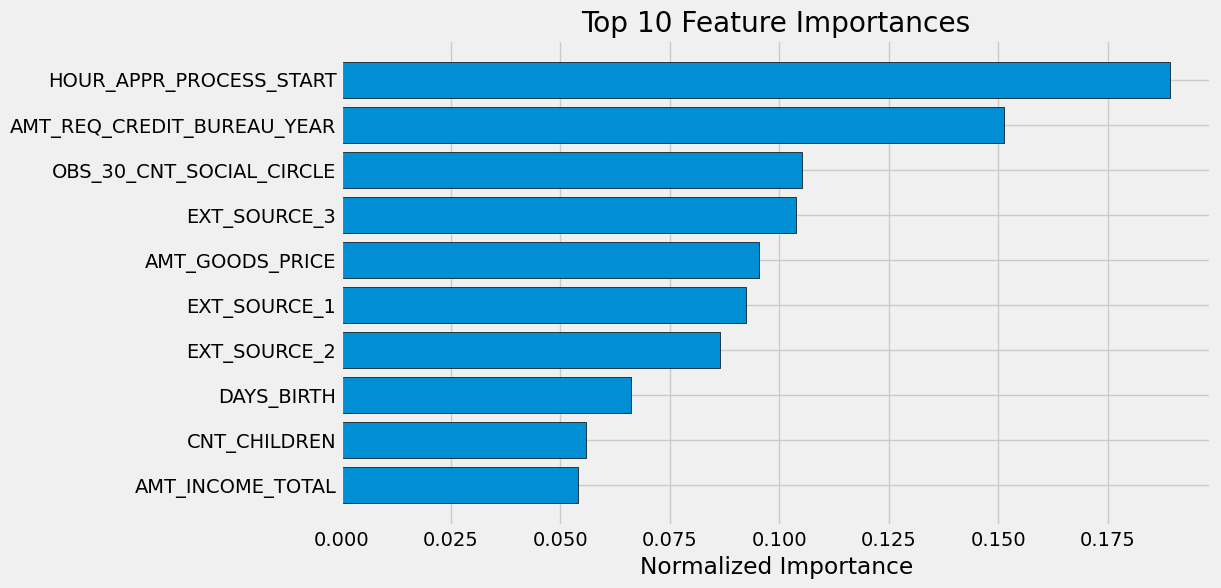

In [109]:
feature_importances_sorted=show_feature_importances(importances, features)

In [110]:
feature_importances_sorted

feature  importance  importance_normalized
0     HOUR_APPR_PROCESS_START         315               0.189189
1  AMT_REQ_CREDIT_BUREAU_YEAR         252               0.151351
2    OBS_30_CNT_SOCIAL_CIRCLE         175               0.105105
3                EXT_SOURCE_3         173               0.103904
4             AMT_GOODS_PRICE         159               0.095495
5                EXT_SOURCE_1         154               0.092492
6                EXT_SOURCE_2         144               0.086486
7                  DAYS_BIRTH         110               0.066066
8                CNT_CHILDREN          93               0.055856
9            AMT_INCOME_TOTAL          90               0.054054

Les 3 variables les + influentes pour ce mod√®le :
- 'HOUR_APPR_PROCESS_START' = √Ä quelle heure environ le client a-t-il demand√© le pr√™t ?
- 'AMT_REQ_CREDIT_BUREAU_YEAR' = Nombre de demandes de renseignements au bureau de cr√©dit concernant le client par jour et par an (√† l'exclusion des trois derniers mois pr√©c√©dant la demande)
- 'OBS_30_CNT_SOCIAL_CIRCLE' : nombre de fois o√π l' entourage  du client a eu des d√©fauts de paiement > 30 jours apr√®s l'√©ch√©ance pr√©vue.

In [ ]:
# feature_importances_sorted.to_csv('feature_importances_sorted_lgbm_1.csv', index=False)

**CONCLUSION** :
----
- Le mod√®le qui parvient le mieux √† distinguer les 2 classes est le LGBM avec une AUC de 0.78 sur le train et 0.75 sur le test
- C'est aussi le mod√®le le plus rapide en terme d'entrainement
- Le seuil optimal pour r√©duire le co√ªt m√©tier est √† 0.10 avec le LGBM. A ce seuil, le mod√®le d√©tecte correctement 63% des instances de la classe 1.
- Le top 3 des variables les + influentes diff√®rent d'un mod√®le √† l'autre mais on retrouve syst√©matiquement une variable qui √©voque le nombre de fois o√π l'entourage social du client a √©t√© enregistr√© comme ayant un retard de paiement.

Nous allons tenter d'am√©liorer le LGBM avec du feature engineering en exploitant notamment les autres datasets fournis